<a href="https://colab.research.google.com/github/invictus125/cs598-final-project/blob/main/intraoperative_hypotension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Reproduction of:
## Predicting intraoperative hypotension using deep learning with waveforms of arterial blood pressure, electroencephalogram, and electrocardiogram

Original paper by: Yong-Yeon Jo, Jong-Hwan Jang, Joon-myoung Kwon, Hyung-Chul Lee, Chul-Woo Jung, Seonjeong Byun, Han‐Gil Jeong

Reproduction project authored by
* Mark Bauer
  * mbauer553
  * markab5@illinois.edu
* Ryan David
  * victheone
  * invictus125
  * radavid2@illinois.edu

This project can be found on github https://github.com/invictus125/cs598-final-project.  

> Note that this project uses <b>VitalDB, an open biosignal dataset.  All users must agree to the Data Use Agreement below.</b>  If after reviewing the agreement you do not comply, please do not read on and close this window.
[Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

## Introduction
Our project is to perform an approximate reproduction of a paper, which can be found [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0272055), on predicting hypotension during surgery from a combination of signals such as mean arterial blood pressure (ABP), electrocardiogram (ECG), and electroencephalogram (EEG) as opposed to ABP alone.  Predicting hypotension is important because it is correlated with many post operation complications, and is actionable.  Please read the original work if you are interested in more detail!

## Scope of reproducibility

We have created what we understand to be a very close replication of the original model and tested it using a smaller, openly-available data set. Our model is capable of using ABP, EEG, and ECG waveforms in any combination, but the focus of our project has been to use ABP only.

Additionally, we have decided to forego the use of the encoder block in our ResNet implementation, as we were never able to get it to train properly. We have generated our results using only the recurring blocks and the fully connected layers.

Finally, we have chosen to use only one look-ahead time, whereas the original paper used several. We are using a look-ahead of 3 minutes for our testing.

## Special Considerations

There was no public code repository for the research paper we attempted to reproduce. As such, all code related to the model, training, and test/evaluation was written by us from scratch.

The description of the autoencoder layers in the paper was not very complete, and we did our best to approximate what we believed they did. We were never able to get this block to work with the rest of our model, even with help from the teaching staff. In spite of this, we were able to train several models which perform fairly well. See our results section to understand the performance we were able to achieve with only ResNets and FC layers.

## Instructions for Using the Notebook

We have stored a subset of data which we have used for training and evaluation on a public Google Drive. The link to the folder is: https://drive.google.com/drive/folders/1--7bdRubDm2DHMbvTmre8aP-og87aqK4?usp=sharing

In order to run this notebook, you will need to put a shortcut to this folder into your personal Google Drive, and then use the following cell to mount the drive. Once you've done so, adjust the `DRIVE_PROJECT_DIR_PATH` parameter in the cell below to match where it is in your drive. For example, in ours it is located at `CS598/Final_Project/`.

If you successfully mount a drive with our shared directory, the rest of the notebook should run without any further intervention.

Please note that we use 100 cases, and it can take approximately 10 minutes to load and parse the data from all of them. There is a cell for loading data from the shared location which can be modified to take fewer cases if desired.

In [1]:
# install dependencies
!pip install torcheval
!pip install vitaldb

# mount drive
# LINK to necessary shared folder: https://drive.google.com/drive/folders/1--7bdRubDm2DHMbvTmre8aP-og87aqK4?usp=sharing

DRIVE_PROJECT_DIR_PATH='./drive/MyDrive/CS598/Final_Project'

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 6.9 MB/s eta 0:00:00
Mounted at /content/drive


# Methodology - Data

Methodology - Data
Case: a surgery/operation

Track: data observed during a case, consisting of a device and type

As of the draft on 2024-04-14 we are getting only ABP data and labels looking ahead one minute.  

In [2]:
from functools import partial
from io import StringIO
from os import listdir
from torch import FloatTensor, BoolTensor

import csv
import numpy as np
import requests
import vitaldb
import math

SEGEMENT_LENGTH_SECONDS = 60

ABP_TRACK = 'SNUADC/ART'
ECG_TRACK = 'SNUADC/ECG_II'
EEG_TRACK = 'BIS/EEG1_WAV'

RELEVANT_TRACKS = [
    ABP_TRACK,
    ECG_TRACK,
    EEG_TRACK,
]


def _url_to_reader(url_string):
    response = requests.get(url_string)
    file = StringIO(response.text)
    return csv.DictReader(file, delimiter=',')


def get_unique_vals(key, iterable):
    return set(map(lambda item: item[key], iterable))


def case_filter(case):
    return float(case['age']) >= 18.0 and case['ane_type'] == 'General'


def _case_track_filter(case_id, case_dict):
    track_list = case_dict[case_id]['tracks']
    return (
        ABP_TRACK in track_list and
        ECG_TRACK in track_list and
        EEG_TRACK in track_list
    )


def _get_candidate_cases():
    cases_by_id = {}
    for case in _url_to_reader('https://api.vitaldb.net/cases'):
        if case_filter(case):
            case['tracks'] = {}
            cases_by_id[case['\ufeffcaseid']] = case

    track_list_reader = _url_to_reader('https://api.vitaldb.net/trks')

    for track in track_list_reader:
        case_id = track['caseid']
        if track['tname'] in RELEVANT_TRACKS:
            if cases_by_id.get(case_id):
                cases_by_id[case_id]['tracks'][track['tname']] = track['tid']

    case_track_filter = partial(_case_track_filter, case_dict=cases_by_id)

    return [case_id for case_id in filter(case_track_filter, cases_by_id.keys())]


def _get_candidate_cases_from_dir(dir_path):
    return [f.split('.vital')[0] for f in listdir(dir_path) if '.vital' in f]


def _download_vital_file(case_id):
    vf = vitaldb.VitalFile(int(case_id), RELEVANT_TRACKS)
    vf.to_vital(case_id+'.vital')


def _get_tracks_from_vital_file(path, tracks, sample_rate):
    vf = vitaldb.read_vital(path, tracks)
    return vf.to_numpy(tracks, sample_rate)


def shuffle_tensors(tensors):
  shuffled_output = []
  shuffled_index = np.array([i for i in range(0, len(tensors[0]))]).astype(int)
  np.random.shuffle(shuffled_index)
  for t in tensors:
    if len(t) > 0:
      new_tensor = t.detach().clone()[shuffled_index]
      shuffled_output.append(new_tensor.squeeze(0))
    else:
      shuffled_output.append(t)

  return shuffled_output


def validate_abp_segment(segment):

    return (
        not np.isnan(segment).any() and
        not (segment > 200).any() and
        not (segment < 30).any() and
        not ((np.max(segment) - np.min(segment)) < 30) and
        not (np.abs(np.diff(segment)) > 30).any() # abrupt changes are assumed to be noise
    )


def download_data(num_requested_cases):
    num_downloaded_cases = 0
    candidate_case_ids = _get_candidate_cases()

    np.random.shuffle(candidate_case_ids)
    for case_id in candidate_case_ids:
        print('Downloading case:', case_id)
        _download_vital_file(case_id)
        num_downloaded_cases = num_downloaded_cases + 1
        at_requested = num_downloaded_cases == num_requested_cases
        if at_requested:
            break

    if not at_requested:
        print('Requsted cases not reached but all available cases exhausted.  ')


def get_data(
    minutes_ahead,
    abp_and_ecg_sample_rate_per_second=500,
    eeg_sample_rate_per_second=128,
    case_ids=None,
    max_num_samples=None,
    max_num_cases=None,
    from_dir=None,
    shuffle_samples=False,
):
    if case_ids is not None:
        candidate_case_ids = case_ids
    elif from_dir is None:
        candidate_case_ids = _get_candidate_cases()
    else:
        candidate_case_ids = _get_candidate_cases_from_dir(from_dir)

    abps = []
    ecgs = []
    eegs = []
    hypotension_event_bools = []

    abp_data_in_two_seconds = 2 * abp_and_ecg_sample_rate_per_second

    at_max = False

    case_count = 0
    np.random.shuffle(candidate_case_ids)
    for case_id in candidate_case_ids:
        case_num_samples = 0
        case_num_events = 0

        print('Getting track data for case:', case_id)
        if from_dir is None:
            case_tracks = vitaldb.load_case(int(case_id), RELEVANT_TRACKS[0:2], 1/abp_and_ecg_sample_rate_per_second)
        else:
            case_tracks = _get_tracks_from_vital_file(f"{from_dir}/{case_id}.vital", RELEVANT_TRACKS[0:2], 1/abp_and_ecg_sample_rate_per_second)

        abp_track = case_tracks[:,0]
        # ecg_track = case_tracks[:,1]

        # eeg_track = vitaldb.load_case(int(case_id), RELEVANT_TRACKS[2], 1/eeg_sample_rate_per_second).flatten()

        for i in range(
            0,
            len(abp_track) - abp_and_ecg_sample_rate_per_second * (SEGEMENT_LENGTH_SECONDS + (1 + minutes_ahead) * SEGEMENT_LENGTH_SECONDS),
            10 * abp_and_ecg_sample_rate_per_second
        ):
            x_segment = abp_track[i:i + abp_and_ecg_sample_rate_per_second * SEGEMENT_LENGTH_SECONDS]
            y_segment_start = i + abp_and_ecg_sample_rate_per_second * (SEGEMENT_LENGTH_SECONDS + minutes_ahead * SEGEMENT_LENGTH_SECONDS)
            y_segement_end = i + abp_and_ecg_sample_rate_per_second * (SEGEMENT_LENGTH_SECONDS + (minutes_ahead + 1) * SEGEMENT_LENGTH_SECONDS)
            y_segment = abp_track[y_segment_start:y_segement_end]

            if validate_abp_segment(x_segment) and validate_abp_segment(y_segment):
                abps.append(x_segment)

                # 2 second moving average
                y_numerator = np.nancumsum(y_segment, dtype=np.float32)
                y_numerator[abp_data_in_two_seconds:] = y_numerator[abp_data_in_two_seconds:] - y_numerator[:-abp_data_in_two_seconds]
                y_moving_avg = y_numerator[abp_data_in_two_seconds - 1:] / abp_data_in_two_seconds

                is_hypotension_event = np.nanmax(y_moving_avg) < 65
                hypotension_event_bools.append(is_hypotension_event)
                case_num_samples = case_num_samples + 1
                if(is_hypotension_event):
                    case_num_events = case_num_events + 1

            at_max_samples = len(hypotension_event_bools) == max_num_samples
            if at_max_samples:
                break

        case_count = case_count + 1
        print(f"Statistics for case: {case_id}, {case_num_samples} total valid samples, {case_num_events} positive samples")

        if at_max_samples or case_count == max_num_cases:
            if at_max_samples:
                print('Max samples reached')
            else:
                print('Max cases reached')
            at_max = True
            break

    if (max_num_samples is not None or max_num_cases is not None) and not at_max:
        print('Max not reached but all available cases exhausted.  ')

    print('Converting and shuffling (if enabled)')

    abps = FloatTensor(abps)
    ecgs = FloatTensor(ecgs)
    eegs = FloatTensor(eegs)
    hypotension_event_bools = BoolTensor(hypotension_event_bools).float()

    if shuffle_samples:
      output_tensors = shuffle_tensors([abps, ecgs, eegs, hypotension_event_bools])
    else:
      output_tensors = [abps, ecgs, eegs, hypotension_event_bools]

    return (
        output_tensors[0].unsqueeze(1),
        output_tensors[1].unsqueeze(1),
        output_tensors[2].unsqueeze(1),
        output_tensors[3]
    )


def _process_loaded_abp_data(all_data, negative_ratio=1.0):
  pos_indices = torch.nonzero(all_data[3] > 0.5).squeeze(-1)
  neg_indices = torch.nonzero(all_data[3] < 0.5).squeeze(-1)
  abp_pos = all_data[0].detach().clone()[pos_indices]
  abp_neg = all_data[0].detach().clone()[neg_indices]

  positive_samples = len(pos_indices)
  cutoff = math.floor(positive_samples * negative_ratio)
  print(f'block has {positive_samples} positives')
  abp_neg = abp_neg[0:cutoff]

  all_abp = torch.concat([abp_neg, abp_pos])
  all_labels = torch.concat([torch.zeros([abp_neg.size()[0]]), torch.ones([abp_pos.size()[0]])])
  shuffled = shuffle_tensors([all_abp, all_labels])
  return [
    shuffled[0],
    torch.Tensor([]),
    torch.Tensor([]),
    shuffled[1]
  ]


In [4]:
# Load data from google drive location
import torch
import pickle

case_list_file = open(f'{DRIVE_PROJECT_DIR_PATH}/cases_with_positive_samples.pkl', 'rb')
case_list = pickle.load(case_list_file)
case_list_file.close()

train_cases = case_list[0:80]
eval_cases = case_list[80:100]

train_data = get_data(3, from_dir=f'{DRIVE_PROJECT_DIR_PATH}/case_set/', case_ids=train_cases)
eval_data = get_data(3, from_dir=f'{DRIVE_PROJECT_DIR_PATH}/case_set/', case_ids=eval_cases)

train_data = _process_loaded_abp_data(train_data, negative_ratio=3.0)
eval_data = _process_loaded_abp_data(eval_data, negative_ratio=3.0)

Getting track data for case: 84
Statistics for case: 84, 1558 total valid samples, 12 positive samples
Getting track data for case: 12
Statistics for case: 12, 1538 total valid samples, 319 positive samples
Getting track data for case: 49
Statistics for case: 49, 606 total valid samples, 2 positive samples
Getting track data for case: 52
Statistics for case: 52, 1292 total valid samples, 130 positive samples
Getting track data for case: 304
Statistics for case: 304, 1105 total valid samples, 17 positive samples
Getting track data for case: 197
Statistics for case: 197, 960 total valid samples, 10 positive samples
Getting track data for case: 244
Statistics for case: 244, 525 total valid samples, 138 positive samples
Getting track data for case: 92
Statistics for case: 92, 239 total valid samples, 92 positive samples
Getting track data for case: 191
Statistics for case: 191, 691 total valid samples, 81 positive samples
Getting track data for case: 263
Statistics for case: 263, 673 total

<ipython-input-2-3b63dcbe1d90>:214: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 370
Statistics for case: 370, 329 total valid samples, 32 positive samples
Getting track data for case: 390
Statistics for case: 390, 1841 total valid samples, 24 positive samples
Getting track data for case: 348
Statistics for case: 348, 820 total valid samples, 7 positive samples
Getting track data for case: 397
Statistics for case: 397, 1486 total valid samples, 451 positive samples
Getting track data for case: 371
Statistics for case: 371, 683 total valid samples, 6 positive samples
Getting track data for case: 330
Statistics for case: 330, 572 total valid samples, 12 positive samples
Getting track data for case: 343
Statistics for case: 343, 859 total valid samples, 14 positive samples
Getting track data for case: 337
Statistics for case: 337, 592 total valid samples, 45 positive samples
Getting track data for case: 375
Statistics for case: 375, 1395 total valid samples, 391 positive samples
Getting track data for case: 384
Statistics for case: 384, 74

# Methodology - Model
Our model is an exact reproduction based on the description provided in the original paper.

There is a ResNet for each of the three waveform types we handle consisting of:

- A CNN encoder layer
- 12 residual blocks, each having two convolutions and two batch normalizations. Alternating blocks will halve the length of the data using a max pooling operation. Per the paper, we also added skip connections by summing the input into the output in each residual block.
- A fully connected output layer which flattens the channels prior to passing through a NN

The model is built such that we can provide one or more ResNets and it will adapt. This is so that we can experiment with varying combinations of input data.

Once the input is run through the ResNets, their output is concatenated and passed through a fully connected layer which ends with a sigmoid activation, producing the final prediction.


In [5]:
import torch
import math
from torch import nn


class EncoderBlock(nn.Module):
  def __init__(self, dim_in, kernel_size=15, stride=1):
    super(EncoderBlock, self).__init__()
    padding = math.floor(kernel_size / 2.0)
    self.conv = nn.Conv1d(1, 1, kernel_size, stride, padding=padding)
    self.mp = nn.MaxPool1d(kernel_size, stride, padding)
    self.fc = nn.Linear(dim_in, dim_in)
    torch.nn.init.normal_(self.fc.weight, mean=0.0, std=0.01)


  def forward(self, x):
    x_hat = self.conv(x)
    x_hat = self.mp(x_hat)
    return self.fc(x_hat)


class ResidualBlock(nn.Module):
  def __init__(
    self,
    in_channels,
    out_channels,
    size_down,
    kernel_size,
    stride=1
  ):
    super(ResidualBlock, self).__init__()

    self.size_down = size_down
    self.in_channels = in_channels
    self.out_channels = out_channels

    padding = math.floor(kernel_size / 2.0)

    self.bn1 = nn.BatchNorm1d(in_channels)
    self.act1 = nn.ReLU()
    self.do = nn.Dropout()
    self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding)
    self.bn2 = nn.BatchNorm1d(in_channels)
    self.act2 = nn.ReLU()
    self.conv2 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
    self.mp = nn.MaxPool1d(kernel_size, padding=padding, stride=2)
    self.conv_for_input = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)


  def forward(self, x):
    x_hat = self.bn1(x)
    x_hat = self.act1(x_hat)
    x_hat = self.do(x_hat)
    x_hat = self.conv1(x_hat)
    x_hat = self.bn2(x_hat)
    x_hat = self.act2(x_hat)
    x_hat = self.conv2(x_hat)

    # Adjust dimensions of input if needed for the skip connection
    x_input = None
    if self.in_channels != self.out_channels:
      x_input = self.conv_for_input(x)
    else:
      x_input = x

    x_hat = x_hat + x_input

    if self.size_down:
      x_hat = self.mp(x_hat)

    return x_hat


class FlattenAndLinearBlock(nn.Module):
  def __init__(self, dim_in, dim_out):
    super(FlattenAndLinearBlock, self).__init__()
    self.fc = nn.Linear(dim_in, dim_out)
    torch.nn.init.normal_(self.fc.weight, mean=0.0, std=0.01)


  def forward(self, x):
    x_hat = torch.flatten(x, start_dim=1, end_dim=-1)
    x_hat = self.fc(x_hat)

    return x_hat


class WaveformResNet(nn.Module):
  def __init__(
    self,
    input_shape,
    output_size,
    data_type,
    use_encoder=False
  ):
    super(WaveformResNet, self).__init__()
    self.use_encoder = use_encoder

    if self.use_encoder:
      self.encoder = EncoderBlock(input_shape, 15, 1)

    self.res_in_dim = input_shape
    self.output_size = output_size
    self.data_type = data_type

    if data_type not in ['abp', 'ecg', 'eeg']:
      raise ValueError('Invalid data type. Must be one of [abp, ecg, eeg]')

    # Set up configurations for residual blocks
    residual_configs = []
    linear_block_input_length = -1
    if data_type in ['abp', 'ecg']:
      residual_configs = [
        {
          'kernel_size': 15,
          'in_channels': 1,
          'out_channels': 2,
          'size_down': True,
        },
        {
          'kernel_size': 15,
          'in_channels': 2,
          'out_channels': 2,
          'size_down': False,
        },
        {
          'kernel_size': 15,
          'in_channels': 2,
          'out_channels': 2,
          'size_down': True,
        },
        {
          'kernel_size': 15,
          'in_channels': 2,
          'out_channels': 2,
          'size_down': False,
        },
        {
          'kernel_size': 15,
          'in_channels': 2,
          'out_channels': 2,
          'size_down': True,
        },
        {
          'kernel_size': 15,
          'in_channels': 2,
          'out_channels': 4,
          'size_down': False,
        },
        {
          'kernel_size': 7,
          'in_channels': 4,
          'out_channels': 4,
          'size_down': True,
        },
        {
          'kernel_size': 7,
          'in_channels': 4,
          'out_channels': 4,
          'size_down': False,
        },
        {
          'kernel_size': 7,
          'in_channels': 4,
          'out_channels': 4,
          'size_down': True,
        },
        {
          'kernel_size': 7,
          'in_channels': 4,
          'out_channels': 6,
          'size_down': False,
        },
        {
          'kernel_size': 7,
          'in_channels': 6,
          'out_channels': 6,
          'size_down': True,
        },
        {
          'kernel_size': 7,
          'in_channels': 6,
          'out_channels': 6,
          'size_down': False,
        },
      ]
      linear_block_input_length = 469 * 6
    else:
      residual_configs = [
        {
          'kernel_size': 7,
          'in_channels': 1,
          'out_channels': 2,
          'size_down': True,
        },
        {
          'kernel_size': 7,
          'in_channels': 2,
          'out_channels': 2,
          'size_down': False,
        },
        {
          'kernel_size': 7,
          'in_channels': 2,
          'out_channels': 2,
          'size_down': True,
        },
        {
          'kernel_size': 7,
          'in_channels': 2,
          'out_channels': 2,
          'size_down': False,
        },
        {
          'kernel_size': 7,
          'in_channels': 2,
          'out_channels': 2,
          'size_down': True,
        },
        {
          'kernel_size': 7,
          'in_channels': 2,
          'out_channels': 4,
          'size_down': False,
        },
        {
          'kernel_size': 3,
          'in_channels': 4,
          'out_channels': 4,
          'size_down': True,
        },
        {
          'kernel_size': 3,
          'in_channels': 4,
          'out_channels': 4,
          'size_down': False,
        },
        {
          'kernel_size': 3,
          'in_channels': 4,
          'out_channels': 4,
          'size_down': True,
        },
        {
          'kernel_size': 3,
          'in_channels': 4,
          'out_channels': 6,
          'size_down': False,
        },
        {
          'kernel_size': 3,
          'in_channels': 6,
          'out_channels': 6,
          'size_down': True,
        },
        {
          'kernel_size': 3,
          'in_channels': 6,
          'out_channels': 6,
          'size_down': False,
        },
      ]
      linear_block_input_length = 120 * 6

    residuals = []
    # Build residuals
    for i in range(12):
      residuals.append(
        ResidualBlock(
          size_down=residual_configs[i]['size_down'],
          in_channels=residual_configs[i]['in_channels'],
          out_channels=residual_configs[i]['out_channels'],
          kernel_size=residual_configs[i]['kernel_size'],
        )
      )

    self.residuals = torch.nn.Sequential(*residuals)

    self.fl_ln = FlattenAndLinearBlock(linear_block_input_length, output_size)


  def forward(self, x):
    if self.use_encoder:
      x_hat = self.encoder(x)
    else:
      x_hat = x

    for i in range(len(self.residuals)):
      x_hat = self.residuals[i](x_hat)

    out = self.fl_ln(x_hat)

    return out


  def get_output_size(self):
    return self.output_size


class IntraoperativeHypotensionModel(nn.Module):
  def __init__(
    self,
    ecg_resnet=None,
    abp_resnet=None,
    eeg_resnet=None
  ):
    super(IntraoperativeHypotensionModel, self).__init__()

    self.ecg = ecg_resnet
    self.abp = abp_resnet
    self.eeg = eeg_resnet

    self.fc_input_length = 0

    if self.ecg is not None:
      self.fc_input_length += self.ecg.get_output_size()

    if self.abp is not None:
      self.fc_input_length += self.abp.get_output_size()

    if self.eeg is not None:
      self.fc_input_length += self.eeg.get_output_size()

    if self.fc_input_length == 0:
      raise 'No resnet blocks provided, unable to build model'

    self.fc1 = nn.Linear(self.fc_input_length, 16)
    self.fc2 = nn.Linear(16, 1)
    self.act = nn.Sigmoid()
    torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
    torch.nn.init.normal_(self.fc2.weight, mean=0.0, std=0.01)


  def forward(self, abp, ecg, eeg):
    all_outs = []

    if self.abp is not None:
      abp_o = self.abp(abp)
      all_outs.append(abp_o)

    if self.ecg is not None:
      ecg_o = self.ecg(ecg)
      all_outs.append(ecg_o)

    if self.eeg is not None:
      eeg_o = self.eeg(eeg)
      all_outs.append(eeg_o)

    resnet_output = torch.concat(all_outs, dim=1)

    intermediate = self.fc1(resnet_output)
    intermediate = self.fc2(intermediate)

    prediction = self.act(intermediate)

    return prediction


# Methodology - Training

### Computational Requirements
- At least 50 GB of RAM
- GPU instance (we have been experimenting with an L4)

### Training Process

The training of this model is fairly straightforward. The paper suggested that we should use Adam as the optimizer and BCE as the loss function, so that is what we have done.

One important thing to note is that we have added the ability to weight loss for positive and negative labels differently. This had to be done, because our dataset is extremely imbalanced.

Another way we have addressed the imbalance of the dataset is by pruning negative samples down to some ratio to the number of positive samples. For most of our testing we have used a 3:1 ratio of negative to positive, whereas the original ratio is about 50:1.

### Training Output

Each training epoch will automatically run evaluation on both the train set and the validation set. See the evaluation methodology for details.

Each training epoch will also save a model checkpoint and performance information to a Google Drive folder (specified using inputs to the train function), as well as graphing the performance on the evaluation set over time.

### Experimentation

#### Hardware

During the course of the project we originally used only CPU-based training. This turned out to be a mistake, as training on a GPU using CUDA decreased our training times by a factor of 100 or more. Originally an epoch would take anywhere from 15 to 20 minutes to complete. Now we complete them in roughly 10-15 seconds.

#### Parameters

We have four easily-modifiable hyperparameters we pass into the train function:
- learning rate
- batch size
- positive loss weight
- negative loss weight

Using these parameters we have been able to experiment with a variety of different training configurations and display the results. See our results section for examples.

In general, we found that weighting the positive cases heavily in loss was a good way to go, as it encouraged the model to keep sensitivity high. Without this, the model would quickly sacrifice sensitivity for the sake of keeping specificity high.

In [11]:
import torch
from torch.optim import Adam
from torch.nn import BCELoss
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from IPython import display


def _extract_batch(data, batch_size, batch_number):
  start = batch_size * batch_number
  end = start + batch_size

  if start >= len(data[3]):
    return None

  return [
      data[0][start:end] if len(data[0]) > 0 else None,
      data[1][start:end] if len(data[1]) > 0 else None,
      data[2][start:end] if len(data[2]) > 0 else None,
      data[3][start:end]
  ]


def _write_train_settings(
    out_dir,
    model_title,
    learning_rate,
    pos_weight,
    neg_weight,
    epochs,
    batch_size
):
  dir = f'{out_dir}/{model_title}'
  !mkdir -p {dir}
  settings_path = f'{dir}/train_settings.txt'
  settings_file = open(settings_path, 'w')
  settings_file.write(f'epochs: {epochs}\nbatch_size: {batch_size}\nlearning_rate: {learning_rate}\npositive_weight: {pos_weight}\nnegative_weight: {neg_weight}')
  settings_file.close()


def _write_perf_checkpoint(out_dir, epoch, model_title, performance):
  dir = f'{out_dir}/{model_title}/perf'
  !mkdir -p {dir}
  perf_path = f'{dir}/{epoch}_perf.txt'
  perf_file = open(perf_path, 'w')
  perf_file.write(f'AUROC: {performance[0]}\nAUPRC: {performance[1]}\nSensitivity: {performance[2]}\nSpecificity: {performance[3]}')
  perf_file.close()


def _write_model_checkpoint(model, out_dir, epoch, model_title):
  dir = f'{out_dir}/{model_title}/checkpoints'
  !mkdir -p {dir}
  model_path = f'{dir}/epoch_{epoch}'
  torch.save(model.state_dict(), model_path)


def show_plot(
    loss_hist,
    auroc_history,
    auprc_history,
    sensitivity_history,
    specificity_history,
    curr_epoch,
    model_title,
    out_dir
):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 15))

    x_tick_range = np.arange(1, curr_epoch+2, 1)

    x_array = range(1, len(loss_hist)+1)

    axes[0].set_title('Loss by Epoch')
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].set_xticks(x_tick_range)

    axes[0].plot(x_array, loss_hist, color='red')

    axes[1].set_title('Metrics by Epoch')
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('mean values')
    axes[1].set_xticks(x_tick_range)
    axes[1].set_yticks(np.arange(0,1,.05))

    axes[1].plot(x_array, auroc_history, color='blue')
    axes[1].plot(x_array, auprc_history, color='green')
    axes[1].plot(x_array, sensitivity_history, color='orange')
    axes[1].plot(x_array, specificity_history, color='gray')
    axes[1].legend(['Auroc', 'Auprc', 'Sensitivity', 'Specificity'])

    plt.tight_layout()
    dir = f'{out_dir}/{model_title}'
    !mkdir -p {dir}
    plt.savefig(f'{dir}/plot.png')
    plt.show()
    display.clear_output(wait=True)


def _train_one_epoch(
  model,
  train_data,
  optimizer,
  device,
  batch_size=32,
  pos_weight=0.9,
  neg_weight=0.1,
):
  start = time.time()
  model.train()
  loss_history = []

  batch_num = 0
  batch = _extract_batch(train_data, batch_size, batch_num)

  while batch is not None:
    # Build weight tensor and criterion function
    weight = batch[3].detach().clone()
    weight = torch.where(weight > 0.5, pos_weight, neg_weight).to(device)
    criterion = BCELoss(weight=weight)

    optimizer.zero_grad()
    abp = batch[0].to(device) if (batch[0] is not None) else None
    ecg = batch[1].to(device) if (batch[1] is not None) else None
    eeg = batch[2].to(device) if (batch[2] is not None) else None
    y = batch[3].to(device)
    y_hat = model(abp, ecg, eeg)
    y_hat = torch.squeeze(y_hat, dim=-1)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    batch_loss = loss.item()
    # print(f'\tBatch {batch_num} loss: {batch_loss}')
    loss_history.append(batch_loss)

    batch_num += 1
    batch = _extract_batch(train_data, batch_size, batch_num)

  end = time.time()

  print(f'Elapsed train time for epoch: {end - start}')

  return loss_history


def train(
  model,
  train_data_handle,
  test_data_handle,
  learning_rate=0.0001,
  epochs=100,
  batch_size=32,
  output_dir=None,
  model_title='ioht_model',
  pos_weight=0.9,
  neg_weight=0.1
):
  """Trains an IntraoperativeHypotensionModel using the given learning rate for
  the given number of epochs

  model: the IntraoperativeHypotensionModel to train
  train_data_handle: the dataset we will train on
  test_data_handle: the dataset we will use for evaluation
  learning_rate: the learning rate to use with the Adam optimizer
  epochs: the number of epochs to train for
  batch_size: the size of batches to train on
  output_dir: the path to an output directory
  model_title: the title of the model to use when writing checkpoints
  pos_weight: weight to apply to the loss for positive cases
  neg_weight: weight to apply to the loss for negative cases
  """
  if model is None or train_data_handle is None or test_data_handle is None:
    raise ValueError(
      'model, train_data_handle, and test_data_handle are required for training'
    )

  # Determine if we can use CUDA / GPU training
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Put the model onto the correct device prior to training
  model.to(device)

  # Write settings if output_dir exists
  if output_dir is not None:
    _write_train_settings(
      output_dir,
      model_title,
      learning_rate,
      pos_weight,
      neg_weight,
      epochs,
      batch_size
    )

  optimizer = Adam(model.parameters(), lr=learning_rate)

  overall_loss_history = []
  auroc_history = []
  auprc_history = []
  sensitivity_history = []
  specificity_history = []

  for epoch in range(epochs):
    loss_history = _train_one_epoch(
      model,
      train_data_handle,
      optimizer,
      device,
      batch_size,
      pos_weight=pos_weight,
      neg_weight=neg_weight
    )
    eval_model(model, train_data_handle, 'Train', device, batch_size)

    performance = eval_model(model, test_data_handle, 'Test', device, batch_size)

    auroc_history.append(performance[0])
    auprc_history.append(performance[1])
    sensitivity_history.append(performance[2])
    specificity_history.append(performance[3])

    _write_perf_checkpoint(
      output_dir,
      epoch,
      model_title,
      performance
    )

    _write_model_checkpoint(
      model,
      output_dir,
      epoch,
      model_title
    )

    mean_loss = np.mean(loss_history)
    overall_loss_history.append(mean_loss)

    show_plot(
      overall_loss_history,
      auroc_history,
      auprc_history,
      sensitivity_history,
      specificity_history,
      epoch,
      model_title,
      output_dir
    )


#  Methodology - Evaluation
The original paper uses four metrics:
- AUROC
- AUPRC
- Sensitivity
- Specificity

We chose to use the torcheval library for our metrics, except for binary specificity which did not appear to be present in torcheval.

In light of that, we have implemented our own binary specificity.

We have also created a test function which can:

- Test a model on a provided set of data
- If applicable, load a model checkpoint



In [7]:
import torch
from torcheval.metrics import BinaryAUROC, BinaryAUPRC, BinaryRecall


def _binary_specificity(test, target):
  # TN / TN + FP
  pinned = torch.where(test >= 0.5, 1.0, 0.0)
  pos = torch.where(pinned > 0, 1.0, 0.0)
  neg = torch.where(pinned < 1, 1.0, 0.0)
  gt_pos = torch.where(target > 0, 1.0, 0.0)
  gt_neg = torch.where(target < 1, 1.0, 0.0)
  tn = neg + gt_neg
  tn = torch.sum(torch.where(tn > 1, 1.0, 0.0), dtype=torch.float)
  fp = pos + gt_neg
  fp = torch.sum(torch.where(fp > 1, 1.0, 0.0), dtype=torch.float)

  return (tn / (tn + fp))


def eval_model(
  model,
  eval_data,
  dataset_name,
  device,
  batch_size=32
):
  # Reduce memory usage during eval
  with torch.no_grad():
    model.eval()

    specificity = []

    f_auroc = BinaryAUROC()
    f_auprc = BinaryAUPRC()
    f_sensitivity = BinaryRecall()

    batch_num = 0
    batch = _extract_batch(eval_data, batch_size, batch_num)

    while batch is not None:
      abp = batch[0].to(device) if batch[0] is not None else None
      ecg = batch[1].to(device) if batch[1] is not None else None
      eeg = batch[2].to(device) if batch[2] is not None else None
      y = batch[3].to(device)

      y_hat = model(abp, ecg, eeg)
      y_hat = y_hat.squeeze(-1)

      y_hat_long = torch.where(y_hat >= 0.5, 1.0, 0.0).long()
      target_long = y.long()

      f_auroc.update(y_hat, y)
      f_auprc.update(y_hat, y)
      f_sensitivity.update(y_hat_long, target_long)
      specificity.append(_binary_specificity(y_hat, y).cpu())

      batch_num += 1
      batch = _extract_batch(eval_data, batch_size, batch_num)

    m_auroc = f_auroc.compute()
    m_auprc = f_auprc.compute()
    m_sensitivity = f_sensitivity.compute()
    m_specificity = np.mean(specificity)

    return (m_auroc, m_auprc, m_sensitivity, m_specificity)


def test(
  model,
  data_handle,
  checkpoint_path=None,
  batch_size=32,
):
  if model is None or data_handle is None:
    raise ValueError(
      'model and data_handle are required for use'
    )

  # Load the checkpoint if there is one specified
  if checkpoint_path is not None:
    model.load_state_dict(torch.load(checkpoint_path))

  # Determine if we can use CUDA / GPU for inference
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Put the model onto the correct device prior to use
  model.to(device)

  performance = eval_model(model, data_handle, 'Test', device, batch_size)

  print(f'Results of testing:')
  print(f'    AUROC: {performance[0]}')
  print(f'    AUPRC: {performance[1]}')
  print(f'    Sensitivity: {performance[2]}')
  print(f'    Specificity: {performance[3]}')




# Results

We have generated results using ABP data and a variety of configurations. All results here were generated using a set of 100 cases. These 100 cases contained several thousand positive samples and many tens of thousands of negative samples. We split the 100 cases 80/20 to create a test and eval set.

In order to mitigate the class imbalance, we pruned the negative samples down to 3x the number of positive samples for each set of data.

Our experiments with different hyperparameters on this dataset included the following configurations:

| Model Title | Learning Rate | Batch Size | Pos Loss Wgt | Neg Loss Wgt | Comments |
| ------ | ------ | ------ | ------ | ------ | ------ |
| abp_only_no_encoder_c3 | 0.001 | 256 | 2.0 | 1.0 | Very noisy training performance due to high learning rate |
| abp_only_no_encoder_c4 | 0.0001 | 256 | 2.0 | 1.0 | Much smoother after lowering learning rate, but poor performance - generally very low sensitivity |
| abp_only_no_encoder_c5 | 0.0001 | 256 | 5.0 | 1.0 | Epoch 21 is our best overall performance of any model checkpoint |
| abp_only_no_encoder_c6 | 0.0001 | 256 | 15.0 | 1.0 | Good model. Sensitivity and specificity converged around 70% on the eval set after many epochs. |
| abp_only_no_encoder_c7 | 0.0001 | 256 | 10.0 | 1.0 | Poor - very low sensitivity. |

Each of the above models has a corresponding graph below to demonstrate how it looked during training. There are also model checkpoints for each epoch stored in our Google Drive and our GitHub repo.

## Train with only ABP

This next section demonstrates results of training on only ABP data with various hyperparameters. It also demonstrates the scalability of our model, allowing us to only use certain resnets if we so choose.

Elapsed train time for epoch: 11.888105630874634


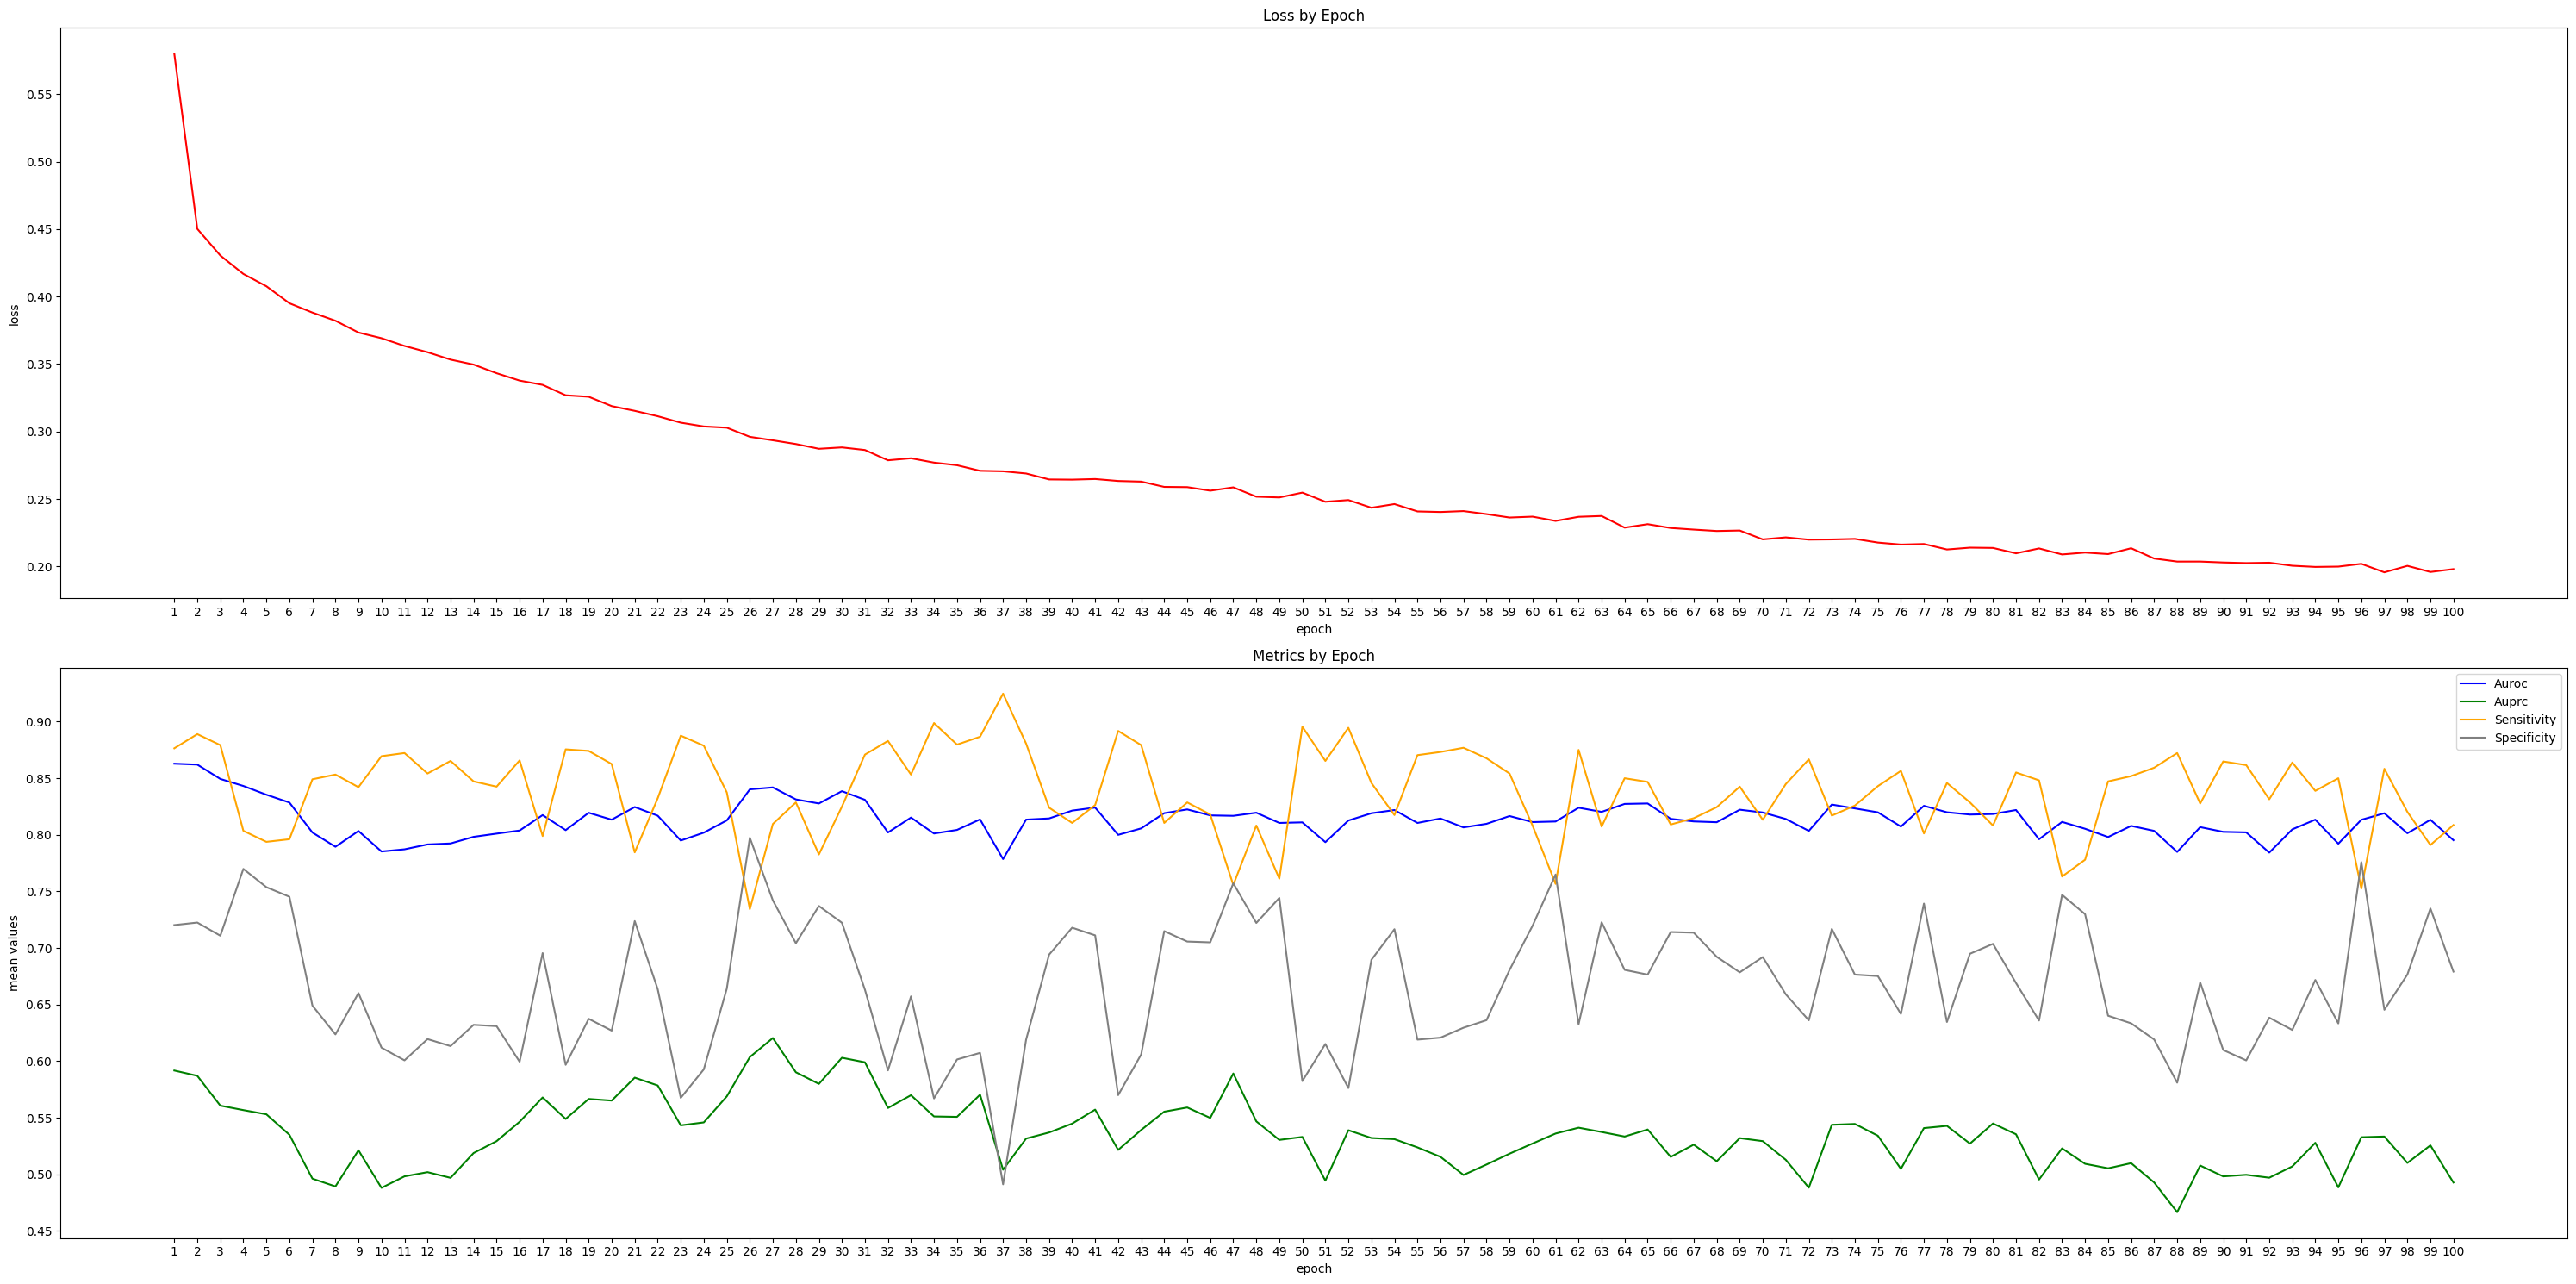

In [12]:
# Put together a model using only ABP
abp_resnet = None
abp_resnet = WaveformResNet(
    input_shape=30000,
    output_size=32,
    data_type='abp',
)

abp_model = IntraoperativeHypotensionModel(
    abp_resnet=abp_resnet
)

train(
    abp_model,
    train_data,
    eval_data,
    batch_size=256,
    epochs=100,
    learning_rate=0.001,
    pos_weight=2.0,
    neg_weight=1.0,
    model_title='abp_only_no_encoder_c3',
    output_dir=f'{DRIVE_PROJECT_DIR_PATH}/model_checkpoints'
)

Elapsed train time for epoch: 11.888382196426392


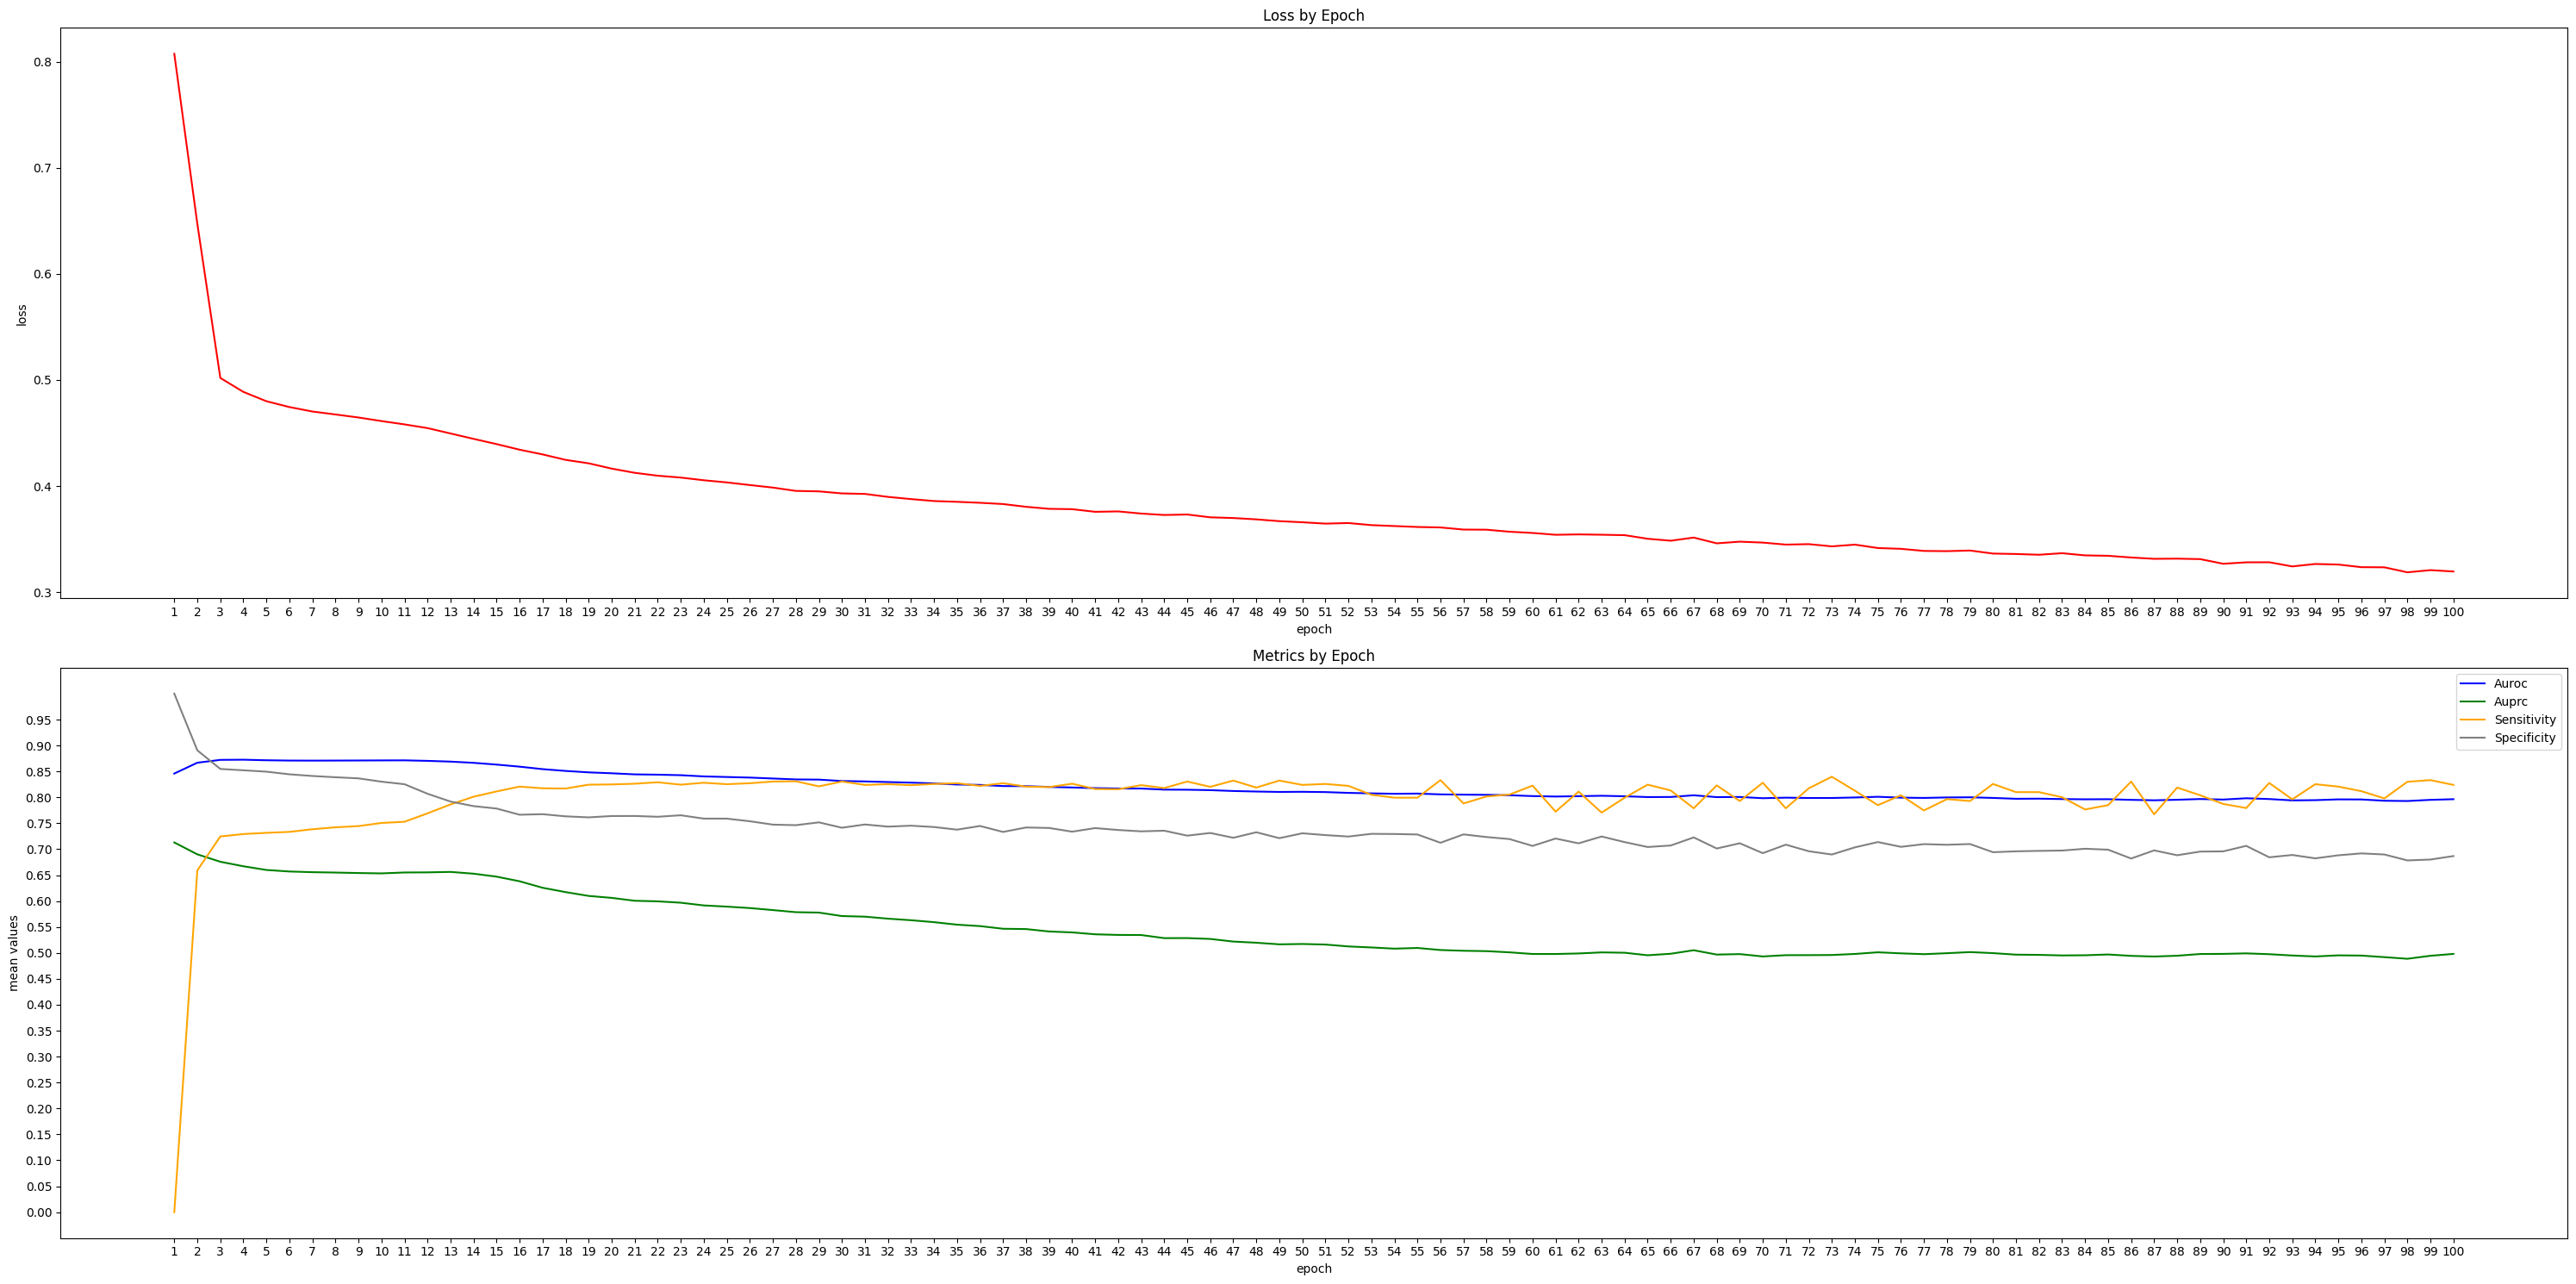

In [13]:
# Put together a model using only ABP
abp_resnet = None
abp_resnet = WaveformResNet(
    input_shape=30000,
    output_size=32,
    data_type='abp',
)

abp_model = IntraoperativeHypotensionModel(
    abp_resnet=abp_resnet
)

train(
    abp_model,
    train_data,
    eval_data,
    batch_size=256,
    epochs=100,
    learning_rate=0.0001,
    pos_weight=2.0,
    neg_weight=1.0,
    model_title='abp_only_no_encoder_c4',
    output_dir=f'{DRIVE_PROJECT_DIR_PATH}/model_checkpoints'
)

Elapsed train time for epoch: 11.889654636383057


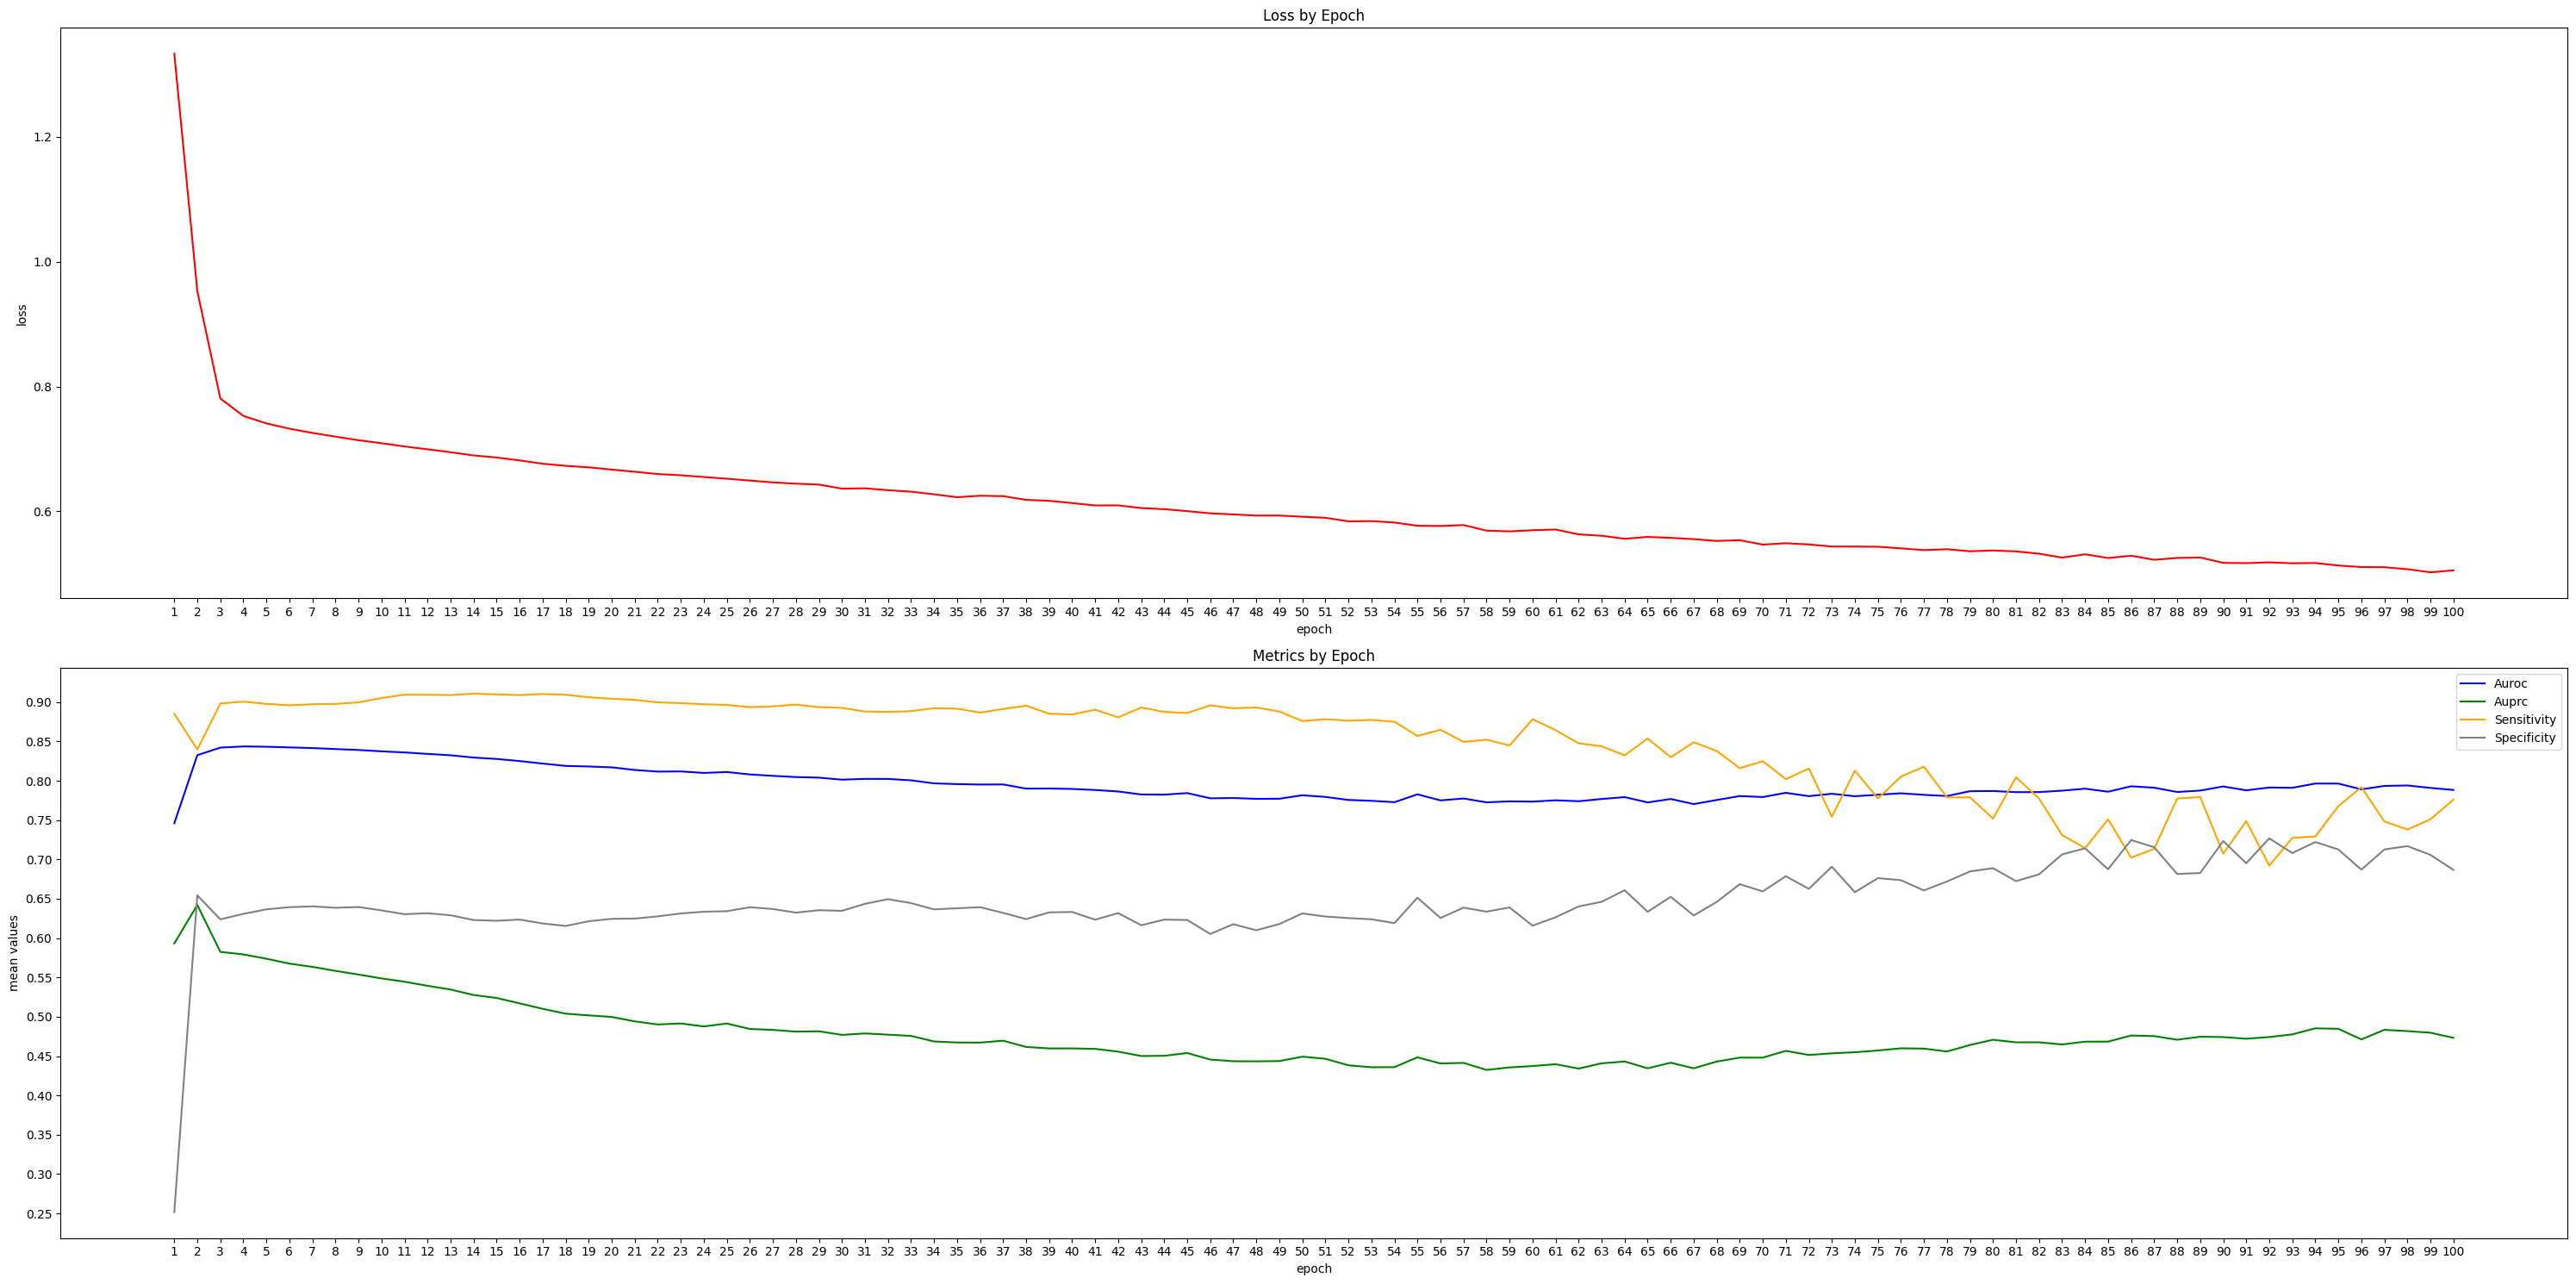

In [14]:
# Put together a model using only ABP
abp_resnet = None
abp_resnet = WaveformResNet(
    input_shape=30000,
    output_size=32,
    data_type='abp',
)

abp_model = IntraoperativeHypotensionModel(
    abp_resnet=abp_resnet
)

train(
    abp_model,
    train_data,
    eval_data,
    batch_size=256,
    epochs=100,
    learning_rate=0.0001,
    pos_weight=5.0,
    neg_weight=1.0,
    model_title='abp_only_no_encoder_c5',
    output_dir=f'{DRIVE_PROJECT_DIR_PATH}/model_checkpoints'
)

Elapsed train time for epoch: 11.894505977630615


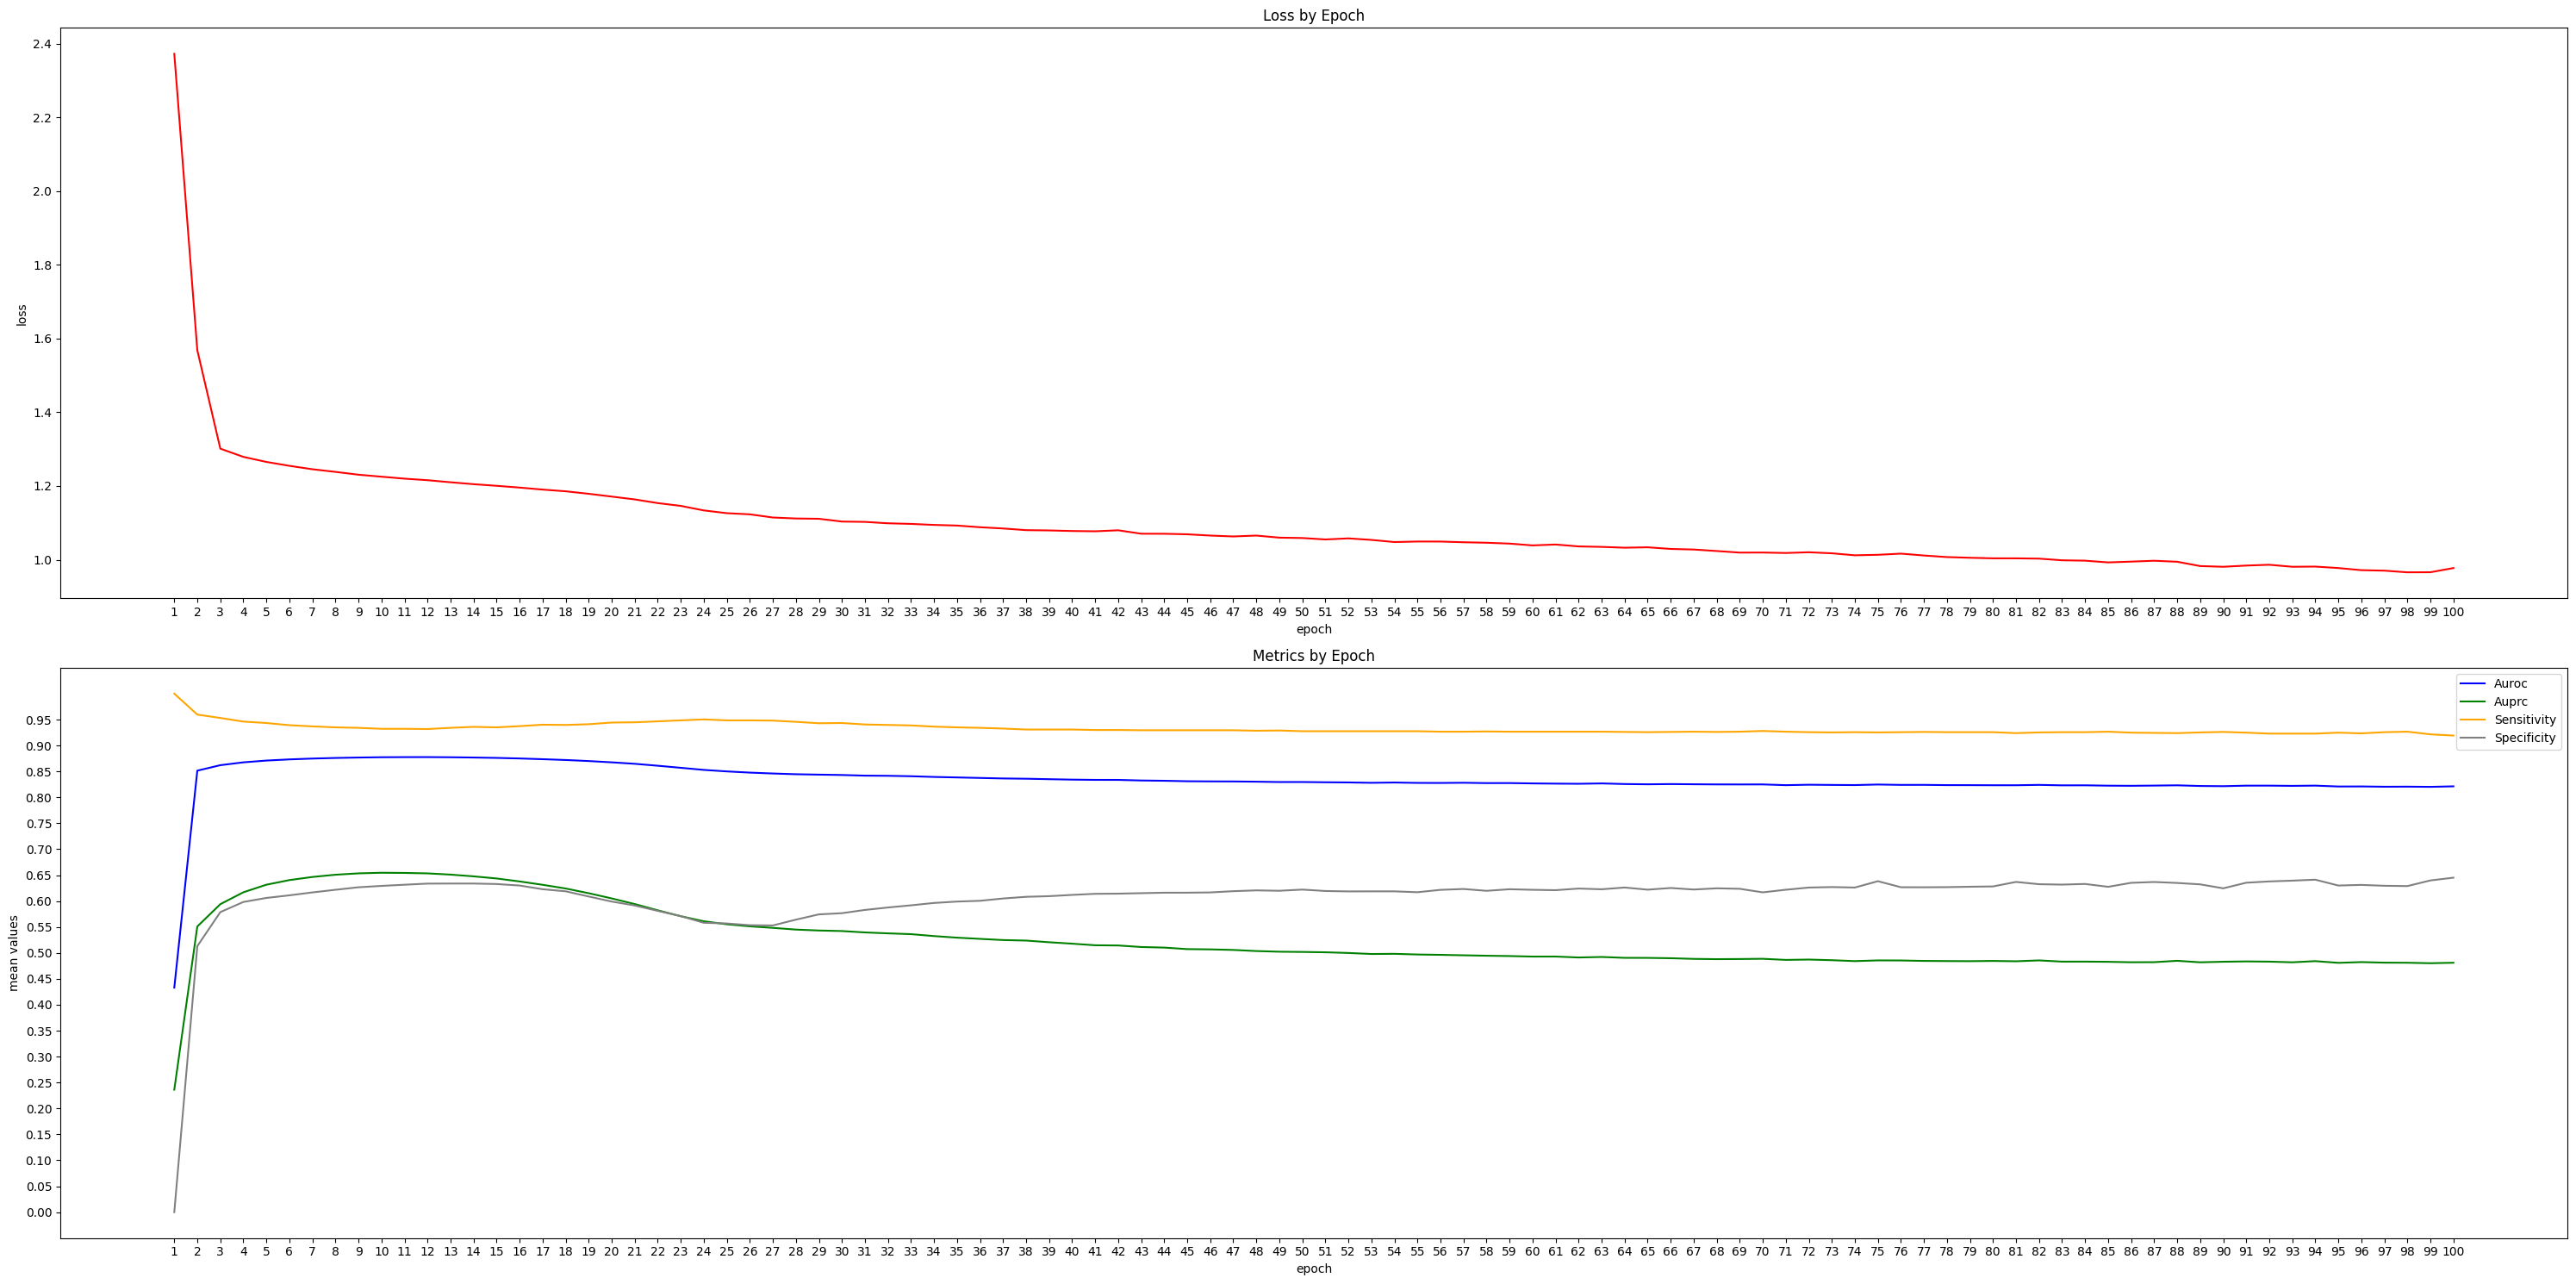

In [15]:
# Put together a model using only ABP
abp_resnet = None
abp_resnet = WaveformResNet(
    input_shape=30000,
    output_size=32,
    data_type='abp',
)

abp_model = IntraoperativeHypotensionModel(
    abp_resnet=abp_resnet
)

train(
    abp_model,
    train_data,
    eval_data,
    batch_size=256,
    epochs=100,
    learning_rate=0.0001,
    pos_weight=15.0,
    neg_weight=1.0,
    model_title='abp_only_no_encoder_c6',
    output_dir=f'{DRIVE_PROJECT_DIR_PATH}/model_checkpoints'
)

Elapsed train time for epoch: 11.893213272094727


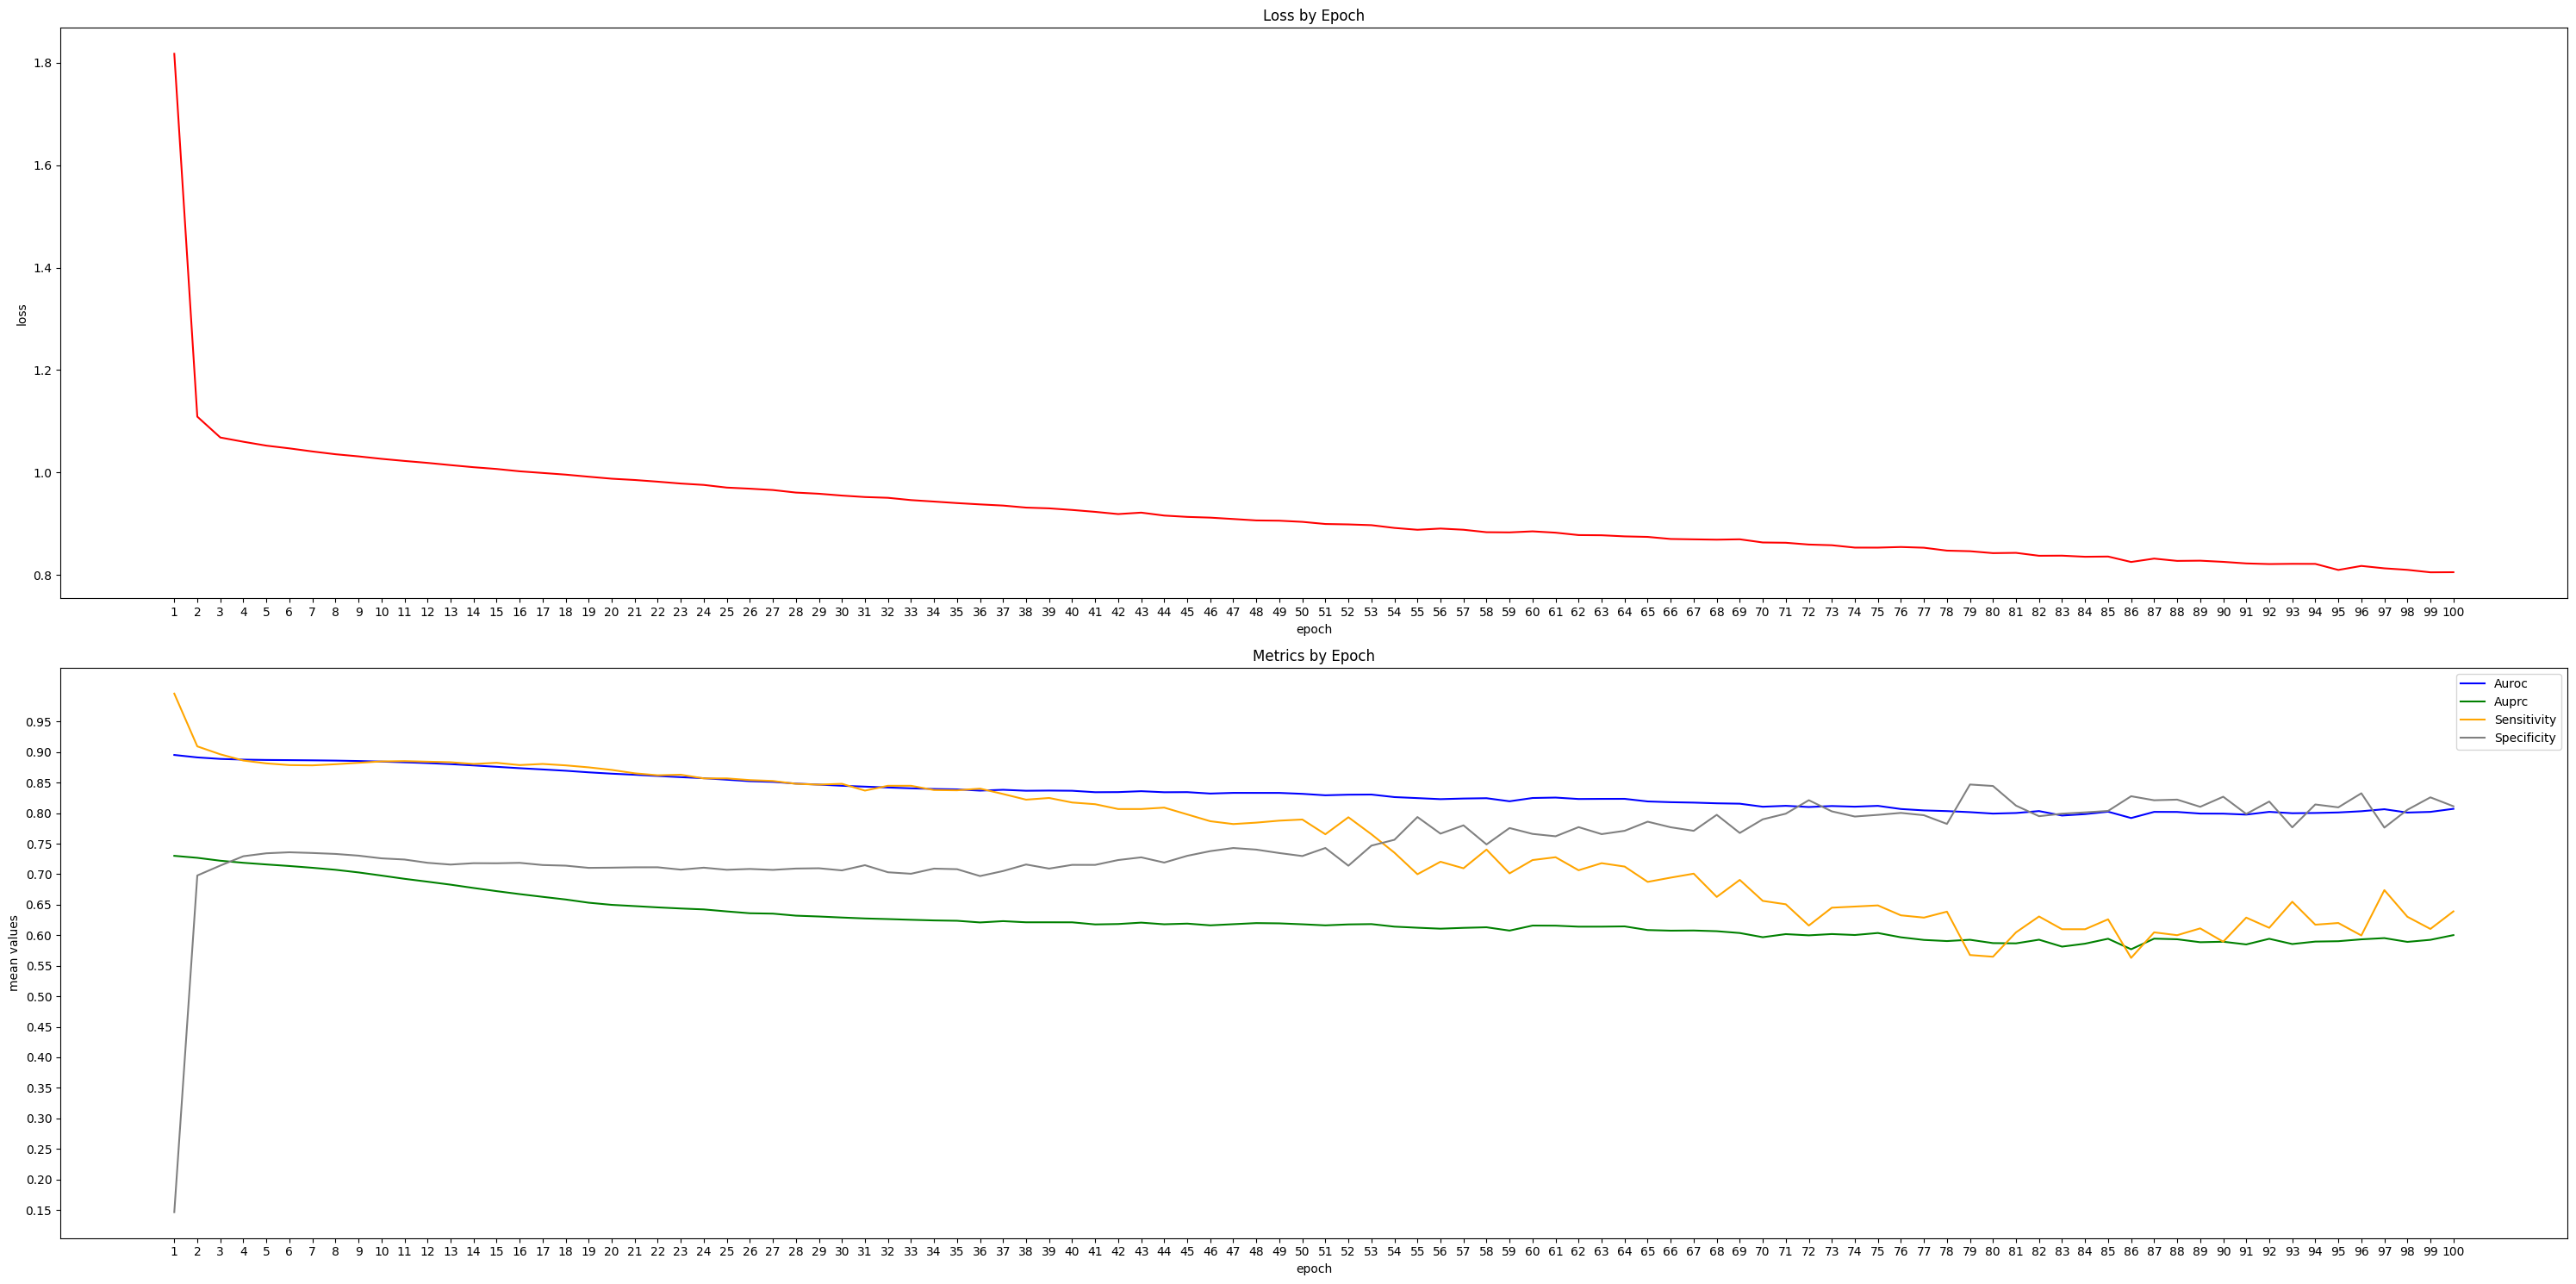

In [16]:
# Put together a model using only ABP
abp_resnet = None
abp_resnet = WaveformResNet(
    input_shape=30000,
    output_size=32,
    data_type='abp',
)

abp_model = IntraoperativeHypotensionModel(
    abp_resnet=abp_resnet
)

train(
    abp_model,
    train_data,
    eval_data,
    batch_size=256,
    epochs=100,
    learning_rate=0.0001,
    pos_weight=10.0,
    neg_weight=1.0,
    model_title='abp_only_no_encoder_c7',
    output_dir=f'{DRIVE_PROJECT_DIR_PATH}/model_checkpoints'
)

### Example of how to load and test one of our model checkpoints

In [17]:
# Load a model from a checkpoint and test it
# This is perhaps our best overall model we have been able to train.

checkpoint_location = f'{DRIVE_PROJECT_DIR_PATH}/model_checkpoints/abp_only_no_encoder_c5/checkpoints/epoch_21'

test(
    abp_model,
    eval_data,
    checkpoint_path=checkpoint_location,
    batch_size=256
)

Results of testing:
    AUROC: 0.8117002548570508
    AUPRC: 0.49021318554878235
    Sensitivity: 0.8996748924255371
    Specificity: 0.6276312470436096


### Example attempting to use the encoder block in the ResNet

This does not work, as evidenced by the unchanging loss and metrics, but we wanted to demonstrate it anyway since we did the work to create the block.

In [18]:
# Put together a model using the encoder
abp_resnet = None
abp_resnet = WaveformResNet(
    input_shape=30000,
    output_size=32,
    data_type='abp',
    use_encoder=True
)

abp_model = IntraoperativeHypotensionModel(
    abp_resnet=abp_resnet
)

train(
    abp_model,
    train_data,
    eval_data,
    batch_size=256,
    epochs=100,
    learning_rate=0.0001,
    pos_weight=15.0,
    neg_weight=1.0,
)

KeyboardInterrupt: 

# References
Jo YY, Jang JH, Kwon Jm, Lee HC, Jung CW, et al. (2022) Predicting intraoperative hypotension using deep learning with waveforms of arterial blood pressure, electroencephalogram, and electrocardiogram: Retrospective study. PLOS ONE 17(8): e0272055. https://doi.org/10.1371/journal.pone.0272055

## Acknowledgements
* As mentioned in the introduction, this project leveraged the open [vitaldb dataset](https://vitaldb.net/dataset/), and without it would have been impossible in its current form.
* Significant inspiration was drawn from [vital db examples](https://github.com/vitaldb/examples)

# Appendix

## Extraneous code / helpful snippets

In [ ]:
# SANITY CHECK
train_data = get_data(3, from_dir='./drive/MyDrive/CS598/Final_Project/case_set/', case_ids=['19'])
eval_data = get_data(3, from_dir='./drive/MyDrive/CS598/Final_Project/case_set/', case_ids=['117'])

train(
    abp_model,
    train_data,
    eval_data,
    batch_size=256,
    epochs=100,
    learning_rate=0.001,
    # model_title='abp_overnight_1',
    # output_dir='./drive/MyDrive/CS598/Final_Project/model_checkpoints'
)

In [ ]:
# Show case stats
import pickle

stats = open(r'cases_with_positive_samples_statistics.pkl', 'rb')
stat_obj = pickle.load(stats)
stats.close()

print(stat_obj)

In [ ]:
import pickle

# Load dataset list and download files to google drive location
case_list_file = open(r'cases_with_positive_samples.pkl', 'rb')
case_list = pickle.load(case_list_file)
case_list_file.close()

for case_id in case_list:
  _download_vital_file(case_id)

!rm -rf ./drive/MyDrive/CS598/Final\ Project/Case\ Set
!mkdir ./drive/MyDrive/CS598/Final\ Project/Case\ Set
!mv ./*.vital ./drive/MyDrive/CS598/Final\ Project/Case\ Set/

In [ ]:
# 15000 total samples should be used for training, 1000 for validation
train_dataset = [
    full_data[0][0:15000].detach().clone(),
    full_data[1].detach().clone(),
    full_data[2].detach().clone(),
    full_data[3][0:15000].detach().clone()
]

eval_dataset = [
    full_data[0][15000:16000].detach().clone(),
    full_data[1].detach().clone(),
    full_data[2].detach().clone(),
    full_data[3][15000:16000].detach().clone()
]

full_data = None

train(abp_model, train_dataset, eval_dataset, batch_size=256, epochs=100)

In [ ]:
!mv ./abp_eval_data_set.pkl ./drive/MyDrive/CS598/Final\ Project/ABP_Datasets/
!mv ./abp_train_data_set.pkl ./drive/MyDrive/CS598/Final\ Project/ABP_Datasets/

In [ ]:
# Read data from ABP dataset at 3-minute before event

import pickle

# Load dataset list and import data 10 cases at a time
case_list_file = open(r'cases_with_positive_samples.pkl', 'rb')
case_list = pickle.load(case_list_file)
case_list_file.close()

data_blocks = []
!rm -rf ./load_now
!mkdir ./load_now

i = 0
for case_id in case_list:
  !cp ./abp_only_cases/{case_id}.vital ./load_now/
  i += 1
  if i == 10:
    # Cut a block
    block = get_data(3, from_dir='./load_now')

    processed = _process_loaded_abp_data(block)

    data_blocks.append(processed)
    !rm ./load_now/*.vital

    i = 0


In [ ]:
# Pickle the data blocks so we can easily load them later and not have to re-generate them
afile = open(r'abp_train_data_sets.pkl', 'wb')
pickle.dump(data_blocks, afile)
afile.close()
data_blocks = None

In [ ]:
# Load the data from the pickle file
data_file = open(r'abp_train_data_sets.pkl', 'rb')
data_blocks = pickle.load(data_file)
data_file.close()

# Split into train and eval sets
eval_dataset = data_blocks[-1]
train_dataset = data_blocks[0:-1]

data_blocks = None # GC

# Train block by block
for idx in range(len(train_dataset)):
  print(f'Training on data block {idx}!!!!')
  train(abp_model, train_dataset[idx], eval_dataset, batch_size=32, epochs=11)

In [ ]:
# # Get exact number of negative samples to match positive ones
# abp_neg = abp_neg[0:167]

# # Concat and shuffle together
# all_abp = torch.concat([abp_neg, abp_pos])
# all_labels = torch.concat([torch.zeros([abp_neg.size()[0]]), torch.ones([abp_pos.size()[0]])])
# shuffled = shuffle_tensors([all_abp, all_labels])

# train_set = [
#     shuffled[0],
#     torch.Tensor([]),
#     torch.Tensor([]),
#     shuffled[1]
# ]

# test_set = [
#     shuffled[0].detach().clone(),
#     torch.Tensor([]),
#     torch.Tensor([]),
#     shuffled[1].detach().clone()
# ]

NameError: name 'abp_neg' is not defined

In [ ]:
# Obtain ABP data to train on
#test_set = get_data(3, max_num_samples=1000)

# Get cases with good data
_download_vital_file('819')
_download_vital_file('3704')

all_data = get_data(3, from_dir='.')

Getting track data for case: 3704
Statistics for case: 3704, 1028 total valid samples, 94 positive samples
Getting track data for case: 819
Statistics for case: 819, 737 total valid samples, 73 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:194: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  abps = FloatTensor(abps)
<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


In [ ]:
# Create a good balanced dataset

pos_indices = torch.nonzero(all_data[3] > 0.5).squeeze(-1)
neg_indices = torch.nonzero(all_data[3] < 0.5).squeeze(-1)
abp_pos = all_data[0].detach().clone()[pos_indices]
abp_neg = all_data[0].detach().clone()[neg_indices]

# Get exact number of negative samples to match positive ones
abp_neg = abp_neg[0:167]

# Concat and shuffle together
all_abp = torch.concat([abp_neg, abp_pos])
all_labels = torch.concat([torch.zeros([abp_neg.size()[0]]), torch.ones([abp_pos.size()[0]])])
shuffled = shuffle_tensors([all_abp, all_labels])

train_set = [
    shuffled[0],
    torch.Tensor([]),
    torch.Tensor([]),
    shuffled[1]
]

test_set = [
    shuffled[0].detach().clone(),
    torch.Tensor([]),
    torch.Tensor([]),
    shuffled[1].detach().clone()
]


In [ ]:
# Train the model on ABP data

# train_set = [
#     all_data[0][0:4000].unsqueeze(1),
#     all_data[1][0:4000].unsqueeze(1),
#     all_data[2][0:4000].unsqueeze(1),
#     all_data[3][0:4000]
# ]

# test_set = [
#     all_data[0][4000:].unsqueeze(1),
#     all_data[1][4000:].unsqueeze(1),
#     all_data[2][4000:].unsqueeze(1),
#     all_data[3][4000:]
# ]

# train(abp_model, train_set, test_set, batch_size=40, epochs=100, learning_rate=0.0001)

# TRAIN ON ONLY CASE 819

# new_train_set = (
#     train_set[0].detach().clone(),
#     train_set[1].detach().clone(),
#     train_set[2].detach().clone(),
#     torch.ones(train_set[3].size(), dtype=torch.float)
# )

# new_test_set = (
#     train_set[0].detach().clone(),
#     train_set[1].detach().clone(),
#     train_set[2].detach().clone(),
#     torch.ones(train_set[3].size(), dtype=torch.float)
# )

train(abp_model, train_set, test_set, batch_size=40, epochs=100)

# TEST WITH RANDOM DATA
# sample_size = 400
# train_set_r = [
#     torch.randn([sample_size, 1, 30000]),
#     torch.randn([sample_size, 1, 30000]),
#     torch.randn([sample_size, 1, 30000]),
#     torch.where(torch.rand([sample_size]) > 0.5, 1.0, 0.0),
# ]

# train(abp_model, train_set_r, train_set_r, batch_size=40, epochs=3)


     Epoch #1
	Batch 0 loss: 0.6892008185386658
	Batch 1 loss: 0.7042883038520813
	Batch 2 loss: 0.6887048482894897
	Batch 3 loss: 0.6910030245780945
	Batch 4 loss: 0.6846761703491211
	Batch 5 loss: 0.6989827752113342
	Batch 6 loss: 0.6940107345581055
	Batch 7 loss: 0.697780966758728
	Batch 8 loss: 0.6829289197921753
y_hat_long sum: 40, target_long sum: 22
y_hat_long sum: 40, target_long sum: 16
y_hat_long sum: 40, target_long sum: 22
y_hat_long sum: 40, target_long sum: 21
y_hat_long sum: 40, target_long sum: 24
y_hat_long sum: 40, target_long sum: 17
y_hat_long sum: 40, target_long sum: 19
y_hat_long sum: 40, target_long sum: 17
y_hat_long sum: 14, target_long sum: 9
    Train data metrics:
        AUROC: 0.9068835883725715
        AUPRC: 0.9036766886711121
        Sensitivity: 1.0
        Specificity: 0.0
y_hat_long sum: 40, target_long sum: 22
y_hat_long sum: 40, target_long sum: 16
y_hat_long sum: 40, target_long sum: 22
y_hat_long sum: 40, target_long sum: 21
y_hat_long sum: 40, 

KeyboardInterrupt: 

In [ ]:
import pickle

# Get cases and find their data counts
candy_cases = _get_candidate_cases()
left_off = rare_candy_cases[-1]
for case_id in candy_cases:
  if int(case_id) <= int(left_off):
    continue

  # Download the case
  _download_vital_file(case_id)

  # Load the case
  all_data = get_data(3, from_dir='.')

  # Analyze positive vs negative ratio
  length = len(torch.flatten(all_data[3]))
  if length > 0:
    pos = torch.sum(all_data[3])
    if pos > 1:
      rare_candy_cases.append(case_id)
      case_distribution[case_id] = { 'positive': pos, 'negative': (length - pos) }

  # Remove the case file
  !rm ./*.vital


Getting track data for case: 152
Statistics for case: 152, 428 total valid samples, 3 positive samples
Getting track data for case: 156
Statistics for case: 156, 0 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 153
Statistics for case: 153, 603 total valid samples, 6 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 156
Statistics for case: 156, 2379 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 160
Statistics for case: 160, 1277 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 161
Statistics for case: 161, 1559 total valid samples, 43 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 163
Statistics for case: 163, 265 total valid samples, 54 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 166
Statistics for case: 166, 1466 total valid samples, 69 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 167
Statistics for case: 167, 789 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 172
Statistics for case: 172, 276 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 175
Statistics for case: 175, 711 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 177
Statistics for case: 177, 1751 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 178
Statistics for case: 178, 1114 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 181
Statistics for case: 181, 986 total valid samples, 17 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 183
Statistics for case: 183, 259 total valid samples, 6 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 184
Statistics for case: 184, 3096 total valid samples, 54 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 186
Statistics for case: 186, 564 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 190
Statistics for case: 190, 1171 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 191
Statistics for case: 191, 691 total valid samples, 81 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 195
Statistics for case: 195, 1430 total valid samples, 15 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 197
Statistics for case: 197, 960 total valid samples, 10 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 198
Statistics for case: 198, 1257 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 199
Statistics for case: 199, 267 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 200
Statistics for case: 200, 677 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 202
Statistics for case: 202, 2664 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 203
Statistics for case: 203, 394 total valid samples, 130 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 206
Statistics for case: 206, 642 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 207
Statistics for case: 207, 0 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  
Getting track data for case: 208
Statistics for case: 208, 654 total valid samples, 10 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 210
Statistics for case: 210, 1509 total valid samples, 20 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 218
Statistics for case: 218, 1237 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 221
Statistics for case: 221, 217 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 222
Statistics for case: 222, 627 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 229
Statistics for case: 229, 1414 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 232
Statistics for case: 232, 1016 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 233
Statistics for case: 233, 958 total valid samples, 47 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 234
Statistics for case: 234, 1232 total valid samples, 4 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 236
Statistics for case: 236, 1764 total valid samples, 16 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 237
Statistics for case: 237, 1859 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 239
Statistics for case: 239, 1067 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 241
Statistics for case: 241, 2333 total valid samples, 114 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 244
Statistics for case: 244, 525 total valid samples, 138 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 247
Statistics for case: 247, 1820 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 250
Statistics for case: 250, 954 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 251
Statistics for case: 251, 1663 total valid samples, 487 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 252
Statistics for case: 252, 1551 total valid samples, 52 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 256
Statistics for case: 256, 1166 total valid samples, 17 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 258
Statistics for case: 258, 675 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 261
Statistics for case: 261, 642 total valid samples, 27 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 263
Statistics for case: 263, 673 total valid samples, 10 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 266
Statistics for case: 266, 1536 total valid samples, 9 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 268
Statistics for case: 268, 418 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 269
Statistics for case: 269, 921 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 270
Statistics for case: 270, 184 total valid samples, 43 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 272
Statistics for case: 272, 441 total valid samples, 10 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 279
Statistics for case: 279, 569 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 281
Statistics for case: 281, 843 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 282
Statistics for case: 282, 757 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 283
Statistics for case: 283, 1143 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 286
Statistics for case: 286, 1002 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 287
Statistics for case: 287, 657 total valid samples, 9 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 293
Statistics for case: 293, 698 total valid samples, 12 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 295
Statistics for case: 295, 912 total valid samples, 18 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 296
Statistics for case: 296, 935 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 297
Statistics for case: 297, 889 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 300
Statistics for case: 300, 590 total valid samples, 42 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 302
Statistics for case: 302, 0 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  
Getting track data for case: 303
Statistics for case: 303, 1452 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 304
Statistics for case: 304, 1105 total valid samples, 17 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 306
Statistics for case: 306, 1644 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 308
Statistics for case: 308, 1551 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 309
Statistics for case: 309, 666 total valid samples, 191 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 312
Statistics for case: 312, 1113 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 316
Statistics for case: 316, 355 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 318
Statistics for case: 318, 613 total valid samples, 90 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 319
Statistics for case: 319, 292 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 321
Statistics for case: 321, 799 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 323
Statistics for case: 323, 787 total valid samples, 106 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 325
Statistics for case: 325, 796 total valid samples, 39 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 326
Statistics for case: 326, 0 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  
Getting track data for case: 327
Statistics for case: 327, 1725 total valid samples, 97 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 330
Statistics for case: 330, 572 total valid samples, 12 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 337
Statistics for case: 337, 592 total valid samples, 45 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 338
Statistics for case: 338, 809 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 342
Statistics for case: 342, 1879 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 343
Statistics for case: 343, 859 total valid samples, 14 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 345
Statistics for case: 345, 1709 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 347
Statistics for case: 347, 185 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 348
Statistics for case: 348, 820 total valid samples, 7 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 349
Statistics for case: 349, 856 total valid samples, 464 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 351
Statistics for case: 351, 0 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  
Getting track data for case: 353
Statistics for case: 353, 1341 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 354
Statistics for case: 354, 1005 total valid samples, 167 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 355
Statistics for case: 355, 741 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 357
Statistics for case: 357, 425 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 358
Statistics for case: 358, 979 total valid samples, 1 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 359
Statistics for case: 359, 1417 total valid samples, 184 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 362
Statistics for case: 362, 1509 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 363
Statistics for case: 363, 1340 total valid samples, 48 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 367
Statistics for case: 367, 1159 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 369
Statistics for case: 369, 1212 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 370
Statistics for case: 370, 329 total valid samples, 32 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 371
Statistics for case: 371, 683 total valid samples, 6 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 375
Statistics for case: 375, 1395 total valid samples, 391 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 380
Statistics for case: 380, 643 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 381
Statistics for case: 381, 0 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  
Getting track data for case: 382
Statistics for case: 382, 1460 total valid samples, 9 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 383
Statistics for case: 383, 430 total valid samples, 1 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 384
Statistics for case: 384, 745 total valid samples, 19 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 386
Statistics for case: 386, 0 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  
Getting track data for case: 387
Statistics for case: 387, 621 total valid samples, 26 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 388
Statistics for case: 388, 1057 total valid samples, 12 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 390
Statistics for case: 390, 1841 total valid samples, 24 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 397
Statistics for case: 397, 1486 total valid samples, 451 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 398
Statistics for case: 398, 738 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 402
Statistics for case: 402, 1269 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 404
Statistics for case: 404, 460 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 405
Statistics for case: 405, 461 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 406
Statistics for case: 406, 1606 total valid samples, 4 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 408
Statistics for case: 408, 717 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 409
Statistics for case: 409, 572 total valid samples, 69 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 413
Statistics for case: 413, 434 total valid samples, 0 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 415
Statistics for case: 415, 536 total valid samples, 39 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 416
Statistics for case: 416, 511 total valid samples, 5 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 417
Statistics for case: 417, 1576 total valid samples, 11 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 418
Statistics for case: 418, 1567 total valid samples, 33 positive samples
Max not reached but all available cases exhausted.  


<ipython-input-2-6f2b2df1b781>:197: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hypotension_event_bools = BoolTensor(hypotension_event_bools).float()


Getting track data for case: 419


KeyboardInterrupt: 

In [ ]:
# pickle the results of case analysis
print(rare_candy_cases)

afile = open(r'cases_with_positive_samples.pkl', 'wb')
pickle.dump(rare_candy_cases, afile)
afile.close()

bfile = open(r'cases_with_positive_samples_statistics.pkl', 'wb')
pickle.dump(case_distribution, bfile)
bfile.close()

['1', '10', '12', '13', '16', '17', '19', '20', '24', '25', '27', '43', '49', '50', '52', '55', '58', '60', '61', '64', '66', '75', '79', '83', '84', '87', '92', '93', '94', '96', '97', '104', '105', '108', '111', '112', '116', '117', '118', '124', '135', '142', '143', '146', '148', '149', '152', '153', '161', '163', '166', '181', '183', '184', '191', '195', '197', '203', '208', '210', '233', '234', '236', '241', '244', '251', '252', '256', '261', '263', '266', '270', '272', '287', '293', '295', '300', '304', '309', '318', '323', '325', '327', '330', '337', '343', '348', '349', '354', '359', '363', '370', '371', '375', '382', '384', '387', '388', '390', '397', '406', '409', '415', '416', '417', '418']


In [ ]:
print(len(rare_candy_cases))

106


In [ ]:
# Put together model as the paper describes (with all resnets)
abp_resnet = WaveformResNet(
    input_shape=30000,
    output_size=32,
    data_type='abp'
)

ecg_resnet = WaveformResNet(
    input_shape=30000,
    output_size=32,
    data_type='ecg'
)

eeg_resnet = WaveformResNet(
    input_shape=7680,
    output_size=32,
    data_type='eeg'
)

model = IntraoperativeHypotensionModel(
    abp_resnet=abp_resnet,
    ecg_resnet=ecg_resnet,
    eeg_resnet=eeg_resnet
)